# Proyecto: Clasificación de Sonidos con CNN utilizando el Dataset ESC-50

## **Introducción**
El objetivo de este proyecto es construir un modelo de redes neuronales convolucionales (CNN) para clasificar sonidos provenientes del dataset **ESC-50**. Este dataset contiene 2,000 clips de audio etiquetados en 50 clases, que incluyen sonidos como ladridos de perros, lluvia, risas, entre otros.

El proyecto está diseñado para implementarse en **Kaggle**, utilizando herramientas modernas de procesamiento de audio y aprendizaje profundo. Aprovecharemos la representación de los clips de audio como espectrogramas de Mel para convertir los datos de audio en entradas visuales adecuadas para una CNN.

Despues, aparte de crear un modelo propio de CNN, implementamos modelos con pesos preentrenados, como VGGish y AST (Audio Spectrogram Transformer) para luego comparar sus eficacias.


Modelos preentrenados escogidos:

Pese a que al principio pensé en usar modelos preentrenados para hacer transfer learning como ResNet50, Inception y EfficientNet, luego me decanté por otros modelos mas especificos para el analisis de audio y espectrogramas, debido a que despues de realizar una prueba de transfer learning con ResNet los resultados fueron uy malos, y tras investigar me di cuenta que se debía al tipo de imagenes con las que los modelos habian sido entrenados, concretamente Resnet y esos modelos habian sido entrenados exclusivamente usando imagenes naturales, por lo que iba a ser imposible que consiguieran generalizar en el analisis de espectrogramas.

# Modelo propio CNN:

## 1. Configuracion del dataset e importacion de librerías.

Lo primero que haré será importar las librerias necesarias para el desarrollo del proyecto, para luego montar el dataset.


In [1]:
# Librerías básicas
import os
import numpy as np
import pandas as pd
import random

# Procesamiento de audio
import librosa
import librosa.display

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de imágenes
import cv2

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    BatchNormalization, Input, Add, GlobalAveragePooling2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

# PyTorch (si se usa en algún momento, por ejemplo con AST)
import torch

# Utilidades
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# ------------------------------------------------------------------------------
# ESTABLECER SEMILLA DE ALEATORIEDAD
# ------------------------------------------------------------------------------
RANDOM_SEED = 42
random.seed(RANDOM_SEED)         # Semilla para random
np.random.seed(RANDOM_SEED)      # Semilla para numpy
tf.random.set_seed(RANDOM_SEED)  # Semilla para TensorFlow
torch.manual_seed(RANDOM_SEED)   # Semilla para PyTorch
torch.cuda.manual_seed_all(RANDOM_SEED)
# ------------------------------------------------------------------------------


In [2]:
dataset_path = '/kaggle/input/dataset/ESC-50-master'
audio_path = os.path.join(dataset_path, 'audio')
meta_path = os.path.join(dataset_path, 'meta/esc50.csv')
tests_path = os.path.join(dataset_path, 'tests')
# Rutas de entrada y salida
output_path = '/kaggle/working/spectrograms'
os.makedirs(output_path, exist_ok=True)

print(dataset_path)
print(audio_path)
print(meta_path)
print(tests_path)

/kaggle/input/dataset/ESC-50-master
/kaggle/input/dataset/ESC-50-master/audio
/kaggle/input/dataset/ESC-50-master/meta/esc50.csv
/kaggle/input/dataset/ESC-50-master/tests


## Preprocesamiento

Esta sección del notebook se encarga de transformar los archivos de audio (.wav) en espectrogramas de mel, que serán utilizados posteriormente para entrenar nuestro modelo de clasificación. El proceso incluye:

- Normalización del audio para consistencia en la amplitud
- Conversión a espectrogramas de mel con parámetros optimizados (n_mels=128, fmax=8000)
- Data augmentation selectiva para mejorar la generalización del modelo
- Normalización de los espectrogramas para un mejor entrenamiento
- Almacenamiento de los espectrogramas procesados en formato .npy


Procesando 2000 archivos de manera secuencial...


Procesando archivos: 100%|██████████| 2000/2000 [02:36<00:00, 12.76archivo/s]


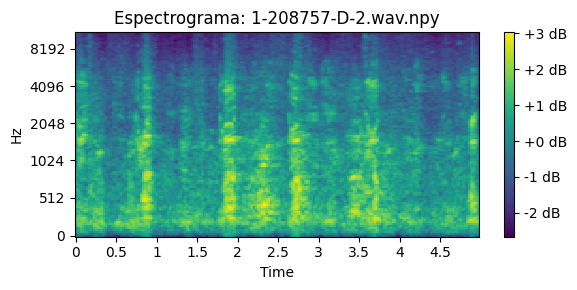

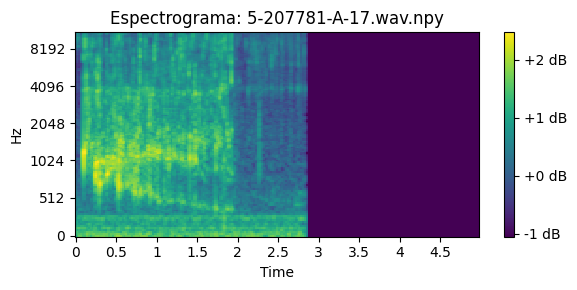

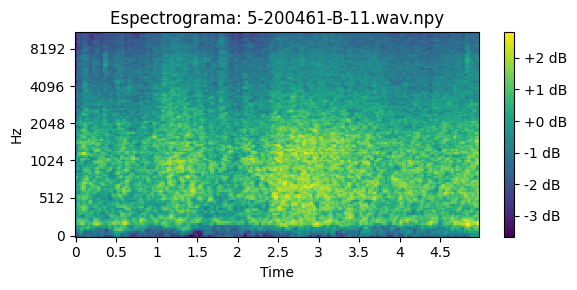

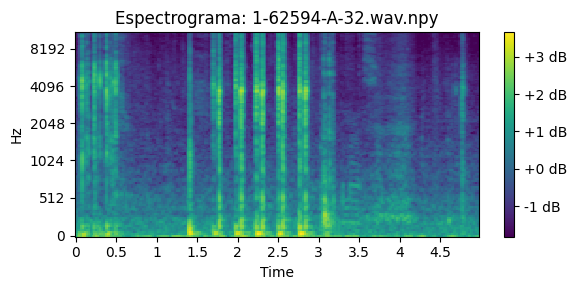

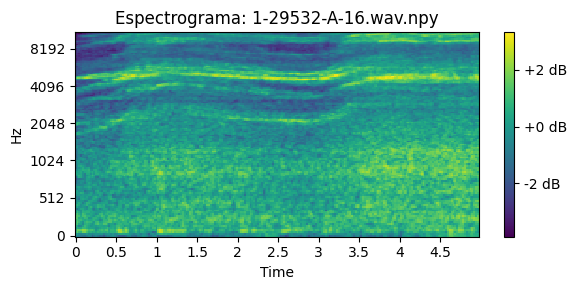

In [3]:
#Celda 3

# Parámetros de audio optimizados para clasificación
AUDIO_PARAMS = {
    'sr': 22050,
    'duration': 5.0,
    'n_mels': 128,
    'n_fft': 2048,
    'hop_length': 512,
    'fmax': 8000
}

def audio_to_melspectrogram(file_path, n_mels=128, fmax=8000, augment=False):
    """Versión mejorada de la función original con augmentación opcional"""
    try:
        # Cargar y normalizar audio
        y, sr = librosa.load(file_path, sr=AUDIO_PARAMS['sr'], duration=AUDIO_PARAMS['duration'])
        
        # Asegurar longitud consistente
        target_length = int(AUDIO_PARAMS['sr'] * AUDIO_PARAMS['duration'])
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]
            
        y = librosa.util.normalize(y)
        
        # Data augmentation para mejorar generalización
        if augment:
            if np.random.random() < 0.5:
                y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))
            if np.random.random() < 0.5:
                y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.95, 1.05))
        
        # Generar espectrograma con parámetros optimizados
        spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=AUDIO_PARAMS['n_fft'],
            hop_length=AUDIO_PARAMS['hop_length'],
            n_mels=n_mels,
            fmax=fmax
        )
        
        # Convertir a dB con rango controlado
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max, top_db=80)
        
        # Normalización robusta
        spectrogram_norm = (spectrogram_db - spectrogram_db.mean()) / (spectrogram_db.std() + 1e-6)
        
        # Forzar dimensión en el eje del tiempo
        max_frames = 215  # aproximado para 5s con sr=22050, hop=512
        current_frames = spectrogram_norm.shape[1]

        if current_frames > max_frames:
            spectrogram_norm = spectrogram_norm[:, :max_frames]
        elif current_frames < max_frames:
            pad_width = max_frames - current_frames
            spectrogram_norm = np.pad(
                spectrogram_norm,
                ((0, 0), (0, pad_width)),
                mode='constant'
            )

        return spectrogram_norm

    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None

def process_and_save(file_name):
    """Función para procesar y salvar espectrogramas con opción de augmentación."""
    file_path = os.path.join(audio_path, file_name)
    try:
        # Generar espectrograma original
        spectrogram = audio_to_melspectrogram(file_path)
        if spectrogram is not None:
            np.save(os.path.join(output_path, f"{file_name}.npy"), spectrogram)
            
            # Generar versión aumentada adicional (30% de probabilidad)
            if np.random.random() < 0.3:
                spectrogram_aug = audio_to_melspectrogram(file_path, augment=True)
                if spectrogram_aug is not None:
                    np.save(os.path.join(output_path, f"{file_name}_aug.npy"), spectrogram_aug)
    except Exception as e:
        print(f"Error con {file_name}: {e}")

def muestra_espectrograma(file_path):
    """
    Visualización optimizada de un espectrograma .npy.
    Aplana la última dimensión si es (H, W, 1).
    """
    spectrogram = np.load(file_path)

    # Aplanar dimensión extra si existe
    if spectrogram.ndim == 3 and spectrogram.shape[-1] == 1:
        spectrogram = spectrogram[..., 0]

    plt.figure(figsize=(6, 3))
    librosa.display.specshow(
        spectrogram,
        x_axis='time',
        y_axis='mel',
        sr=AUDIO_PARAMS['sr'],
        hop_length=AUDIO_PARAMS['hop_length'],
        cmap='viridis'
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Espectrograma: {os.path.basename(file_path)}")
    plt.tight_layout()
    plt.show()



# Obtener la lista de archivos de audio
audio_files = [f for f in os.listdir(audio_path) if f.endswith('.wav')]

# Procesamiento secuencial con barra de progreso
print(f"Procesando {len(audio_files)} archivos de manera secuencial...")
for file_name in tqdm(audio_files, desc="Procesando archivos", unit="archivo"):
    process_and_save(file_name)

# Mostrar resultados de algunos espectrogramas
spectrogram_files = [f for f in os.listdir(output_path) if f.endswith('.npy')]
for spectrogram_file in spectrogram_files[:5]:
    muestra_espectrograma(os.path.join(output_path, spectrogram_file))


### **Visualización de las Clases**
A continuación, se mostrará una lista de todas las clases presentes en el dataset junto con su frecuencia. Todas las clases tienen el mismo número de ejemplos (40 por clase), lo que asegura un balance perfecto en los datos. Además, cada clase pertenece a una categoría bien definida como animales, sonidos humanos, naturaleza, entre otros.

Esta información se puede usar para analizar cómo está estructurado el dataset y diseñar las estrategias de preprocesamiento, entrenamiento y evaluación del modelo.



Cargando la metadata...
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Clases únicas (primeras 30 y últimas 10):
0: dog
1: chirping_birds
2: vacuum_cleaner
3: thunderstorm
4: door_wood_knock
5: can_opening
6: crow
7: clapping
8: fireworks
9: chainsaw
10: airplane
11: mouse_click
12: pouring_water
13: train
14: sheep
15: water_drops
16: church_bells
17: clock_alarm
18: keyboard_typing
19: wind
20: footsteps
21: frog
22: cow
23: brushing_teeth
24: car_horn
25: crackling_fire
26: helicopter
27: drinking_sipping
28: rain
29: insects
40: pig
41: washing_machine
42: clock_tick
43: sneezing
44: rooster
45: 

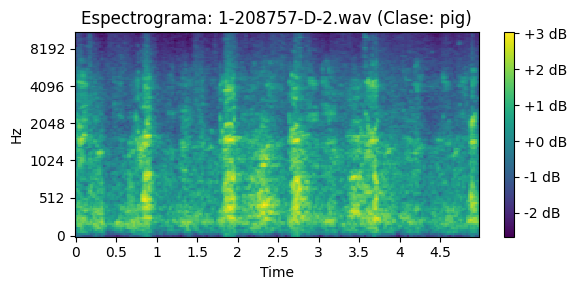

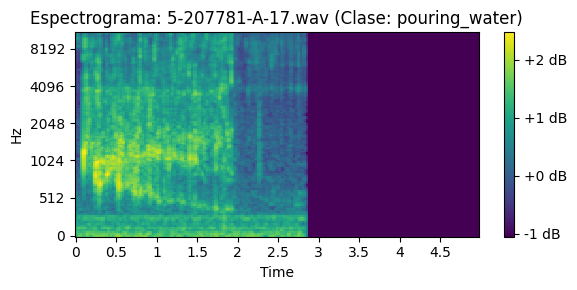

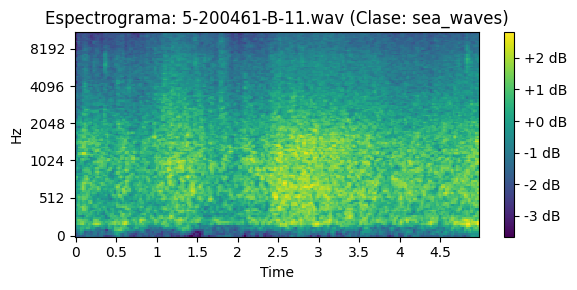

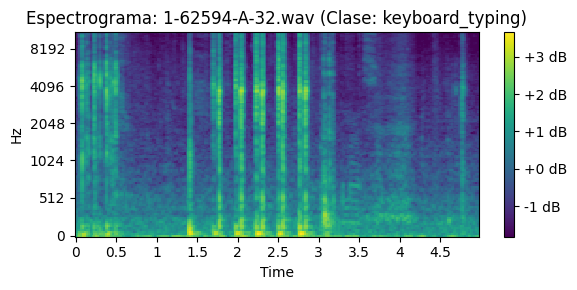

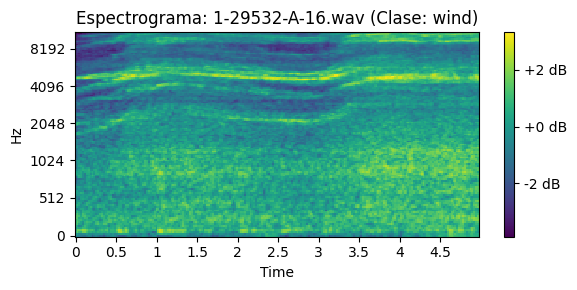

In [4]:
# Cargar la metadata
def explore_metadata(meta_path):
    print("\nCargando la metadata...")
    metadata = pd.read_csv(meta_path)
    print(metadata.head())

    # Lista de las clases únicas en el dataset
    unique_classes = metadata['category'].unique()
    print("\nClases únicas (primeras 30 y últimas 10):")
    for i, category in enumerate(unique_classes[:30]):
        print(f"{i}: {category}")
    for i, category in enumerate(unique_classes[-10:], start=len(unique_classes) - 10):
        print(f"{i}: {category}")

    return metadata

# Función para mostrar un espectrograma con su clase
def muestra_espectrograma_con_clase(file_path, metadata):
    file_name = os.path.basename(file_path).replace('.npy', '')
    try:
        # Buscar la clase correspondiente
        clase = metadata.loc[metadata['filename'] == file_name, 'category'].values[0]
        spectrogram = np.load(file_path)

        plt.figure(figsize=(6, 3))
        librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Espectrograma: {file_name} (Clase: {clase})")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error mostrando {file_name}: {e}")

# Función para cargar espectrograma y etiqueta
def load_spectrogram_and_label(row, output_path):
    file_path = os.path.join(output_path, row['filename'] + '.npy')
    try:
        spectrogram = np.load(file_path)
        label = row['target']
        return spectrogram, label
    except Exception as e:
        print(f"Error cargando {file_path}: {e}")
        return None, None

# Llamar a la función
metadata = explore_metadata(meta_path)

# Visualizar espectrogramas de varias clases
spectrogram_files = [f for f in os.listdir(output_path) if f.endswith('.npy')]
for spectrogram_file in spectrogram_files[:5]:  # Mostrar 5 ejemplos
    muestra_espectrograma_con_clase(os.path.join(output_path, spectrogram_file), metadata)

# Crear dataset con espectrogramas y etiquetas
spectrograms, labels = [], []
for _, row in metadata.iterrows():
    spectrogram, label = load_spectrogram_and_label(row, output_path)
    if spectrogram is not None:
        spectrograms.append(spectrogram)
        labels.append(label)

spectrograms = np.array(spectrograms)
labels = np.array(labels)


### Division del dataset en entrenamiento, validacion y test

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    spectrograms, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\nTamaños de los conjuntos:")
print(f"Entrenamiento: {len(X_train)} ejemplos")
print(f"Validación: {len(X_val)} ejemplos")
print(f"Prueba: {len(X_test)} ejemplos")



Tamaños de los conjuntos:
Entrenamiento: 1400 ejemplos
Validación: 300 ejemplos
Prueba: 300 ejemplos


Cross validation

In [6]:
from sklearn.model_selection import KFold

def cross_validate_model(model_builder_fn, X_data, y_data, folds=5, batch_size=32, epochs=5):
    kfold = KFold(n_splits=folds, shuffle=True, random_state=42)
    cv_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_data)):
        print(f"[CV] Iniciando fold {fold_idx+1}/{folds}...")

        model_cv = model_builder_fn()
        model_cv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        history_cv = model_cv.fit(
            X_data[train_idx], y_data[train_idx],
            validation_data=(X_data[val_idx], y_data[val_idx]),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[early_stopping]
        )

        best_val_acc = max(history_cv.history['val_accuracy'])
        cv_scores.append(best_val_acc)
        print(f"[CV] Fold {fold_idx+1} finalizó con best_val_accuracy={best_val_acc:.4f}\n")

    return cv_scores



# Exploración y Explicación de la Metadata del Dataset ESC-50

El dataset ESC-50 contiene 2,000 clips de audio distribuidos en 50 clases, organizados de manera uniforme. Cada archivo de audio está etiquetado con información relevante, almacenada en el archivo `esc50.csv`. Esta metadata proporciona información estructurada que es crucial para organizar y entrenar un modelo de clasificación.

## **Columnas Principales de la Metadata**
1. **filename**:
   - Nombre del archivo de audio correspondiente (por ejemplo, `1-100032-A-0.wav`).
   - Estructura del nombre:
     - `<fold>-<source_file>-<take>-<class_id>.wav`
     - Ejemplo: `1-137-A-32.wav` donde:
       - `1`: Fold asignado para validación cruzada.
       - `137`: ID del archivo fuente.
       - `A`: Toma específica del audio.
       - `32`: Índice de la clase asociada.

2. **fold**:
   - Número de partición asignada (1 a 5).
   - Utilizado para validación cruzada en los experimentos.

3. **target**:
   - Índice numérico de la clase del sonido (de 0 a 49).
   - Este índice se utiliza directamente como etiqueta para entrenar el modelo.

4. **category**:
   - Nombre de la clase correspondiente (por ejemplo, `dog`, `rain`, etc.).
   - Estas son las categorías de alto nivel que queremos predecir con el modelo.

5. **esc10**:
   - Indicador binario (0 o 1) que identifica si un clip pertenece al subconjunto ESC-10 (un conjunto reducido con 10 clases).

6. **src_file**:
   - ID del archivo fuente original antes de su partición.

7. **take**:
   - Identificador único de la toma del archivo (por ejemplo, `A`).

### Switch de aceleradores

En esta celda hago un bloque que capture el acelerador que se esta usando y lo tenga en cuenta para el resto de codigo. Esto lo hice en vista de que para usar TPU o GPU por ejemplo en kaggle se requieren pequeños cambios en el codigo y por tanto pensé que sería mejor practica tener una celda que gestionase esto en tiempo de ejecucion.

In [7]:
# Detectar el acelerador disponible
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f"Se encontró una TPU: {tpu}")
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)  # Usar estrategia de TPU
    print("TPU activada correctamente.")
except ValueError:
    # Si no hay TPU, usar GPU o CPU
    gpus = tf.config.experimental.list_logical_devices("GPU")
    if gpus:
        strategy = tf.distribute.MirroredStrategy()
        print(f"Se encontraron GPUs: {len(gpus)}")
    else:
        strategy = tf.distribute.get_strategy()
        print("Se usará CPU como acelerador.")

print("Estrategia en uso:", strategy)


Se encontraron GPUs: 1
Estrategia en uso: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7bf0c74aa6e0>


## **Diseño modelo propio**

Esta es la construccion de mi modelo CNN para clasificar los espectrogramas.

In [8]:
#Construcción y Diseño de un Modelo CNN para Clasificación Multiclase
tf.keras.backend.set_floatx('float32')

#Codificar las etiquetas en formato one-hot
# Las etiquetas se convierten en vectores binarios para clasificación multiclase
# Por ejemplo, una etiqueta '3' se convierte en [0, 0, 0, 1, 0, ..., 0]
y_train_one_hot = to_categorical(y_train, num_classes=50)
y_val_one_hot = to_categorical(y_val, num_classes=50)
y_test_one_hot = to_categorical(y_test, num_classes=50)
print("Etiquetas convertidas a one-hot")

Etiquetas convertidas a one-hot


In [9]:
# Paso 3: Definir el modelo CNN
# El modelo consta de 3 bloques principales de capas convolucionales seguidas de capas de agrupación
# Además, incluye BatchNormalization para estabilizar el aprendizaje y Dropout para evitar el sobreajuste

def create_residual_block(inputs, filters, kernel_size=(3, 3)):
    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    if inputs.shape[-1] != filters:
        inputs = Conv2D(filters, (1, 1))(inputs)
    
    return Add()([x, inputs])

def build_optimized_model(input_shape, num_classes=50):
    inputs = Input(shape=input_shape)
    
    # Initial convolution block
    #x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    #x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    x = create_residual_block(x, 64)
    x = MaxPooling2D((2, 2))(x)
    
    x = create_residual_block(x, 128)
    x = MaxPooling2D((2, 2))(x)
    
    x = create_residual_block(x, 256)
    x = MaxPooling2D((2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) #antes 0.5
    
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x) #antes 0.3
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

## Configuracion del entrenamiento

In [10]:
# Función para configurar el entrenamiento
def setup_training(model, optimizer_type='adam'):

    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=0.0001)
    elif optimizer_type == 'sgd':
        optimizer = SGD(learning_rate=0.01, momentum=0.9)
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate=0.0005)
    elif optimizer_type == 'adam2':
        optimizer = Adam(learning_rate=0.001, decay=1e-6)

    # Learning rate scheduler
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # Compilar modelo con configuración optimizada
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return [reduce_lr, early_stopping]



### Definir y compilar el modelo:
(Usando la strategy definida antes)

In [11]:
with strategy.scope():
    # Asumiendo que X_train tiene forma (samples, height, width, channels)
    input_shape = (128, X_train.shape[2], 1)
    
    # Construcción del modelo
    model_propio = build_optimized_model(input_shape)
    
    # Callbacks y configuración básica (ReduceLROnPlateau, EarlyStopping)
    callbacks = setup_training(model_propio)

    #Data augmentation ya implementada

    print("Modelo compilado")

# Resumen del modelo
model_propio.summary()

Modelo compilado


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 215, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 215, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 215, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 108, 64)    │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 108, 64)    │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 108, 64)    │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 108, 64)    │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 108, 64)    │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 108, 64)    │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 54, 64)     │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 54, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 54, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 54, 128)    │        147,584 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 54, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 54, 128)    │          8,320 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 1,505,202 (5.74 MB)

 Trainable params: 1,501,746 (5.73 MB)

 Non-trainable params: 3,456 (13.50 KB)

## Entrenamiento (Fit)

In [12]:
# Entrenamiento del modelo CNN


# Definir callbacks
# EarlyStopping para detener el entrenamiento si no hay mejora
# ModelCheckpoint para guardar el mejor modelo basado en la precisión de validación
#model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
#Celda 13

# Entrenamiento del modelo CNN
batch_size = 128 if isinstance(strategy, tf.distribute.TPUStrategy) else 32

# (Opcional) Cross-validation (ejemplo con pocas épocas)
cv_scores_propio = cross_validate_model(
    lambda: build_optimized_model((128, X_train.shape[2], 1)),
    X_train,         # datos de entrenamiento
    y_train_one_hot, # etiquetas en one-hot
    folds=5,
    batch_size=batch_size,
    epochs=30
)
print(f"[CV] Promedio de accuracy en cross-validation (modelo propio): {np.mean(cv_scores_propio):.4f}")

# Entrenamiento "final"
history = model_propio.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=50,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# Guardar el modelo final
model_propio.save("final_model.keras")


[CV] Iniciando fold 1/5...
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.0580 - loss: 10.8212 - val_accuracy: 0.0464 - val_loss: 9.8884
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.1417 - loss: 9.1735 - val_accuracy: 0.0214 - val_loss: 9.6776
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.2172 - loss: 8.1421 - val_accuracy: 0.0214 - val_loss: 9.9645
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.2949 - loss: 7.1857 - val_accuracy: 0.0214 - val_loss: 8.9763
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3350 - loss: 6.5233 - val_accuracy: 0.0214 - val_loss: 8.8918
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4203 - loss: 5.7783 - val_accuracy: 0.0357 - val_loss: 8.5465
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5029 - loss: 5.1875 - val_accuracy: 0.0357 - val_loss: 8.3372
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5611 - loss: 4.5

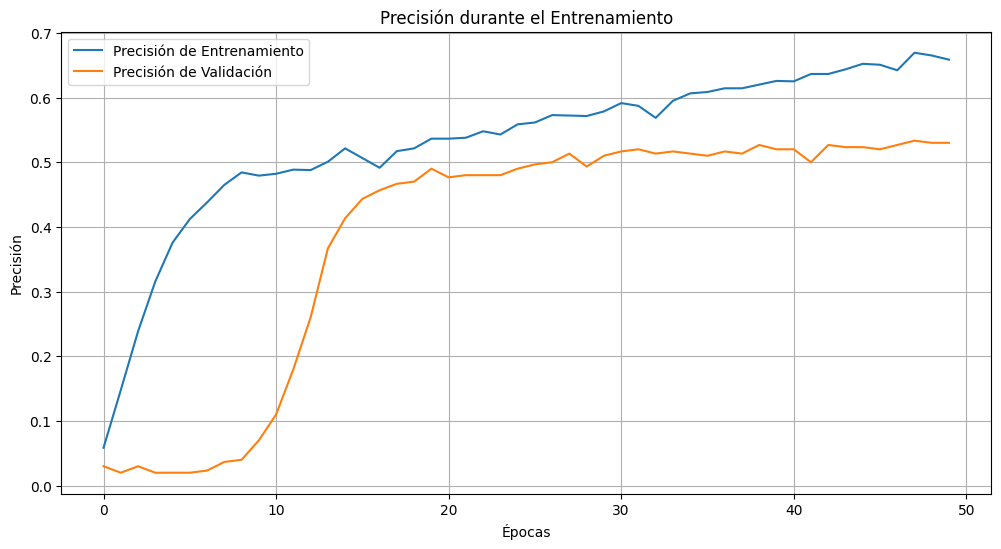

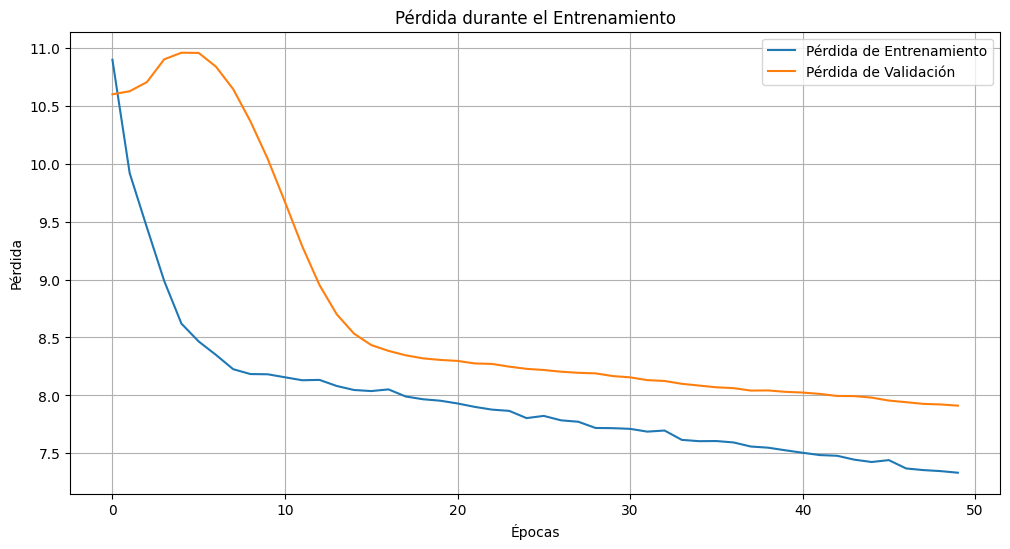

In [13]:
# Visualizar curvas de aprendizaje
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()


## Prediccion y definicion de funciones de evaluacion

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


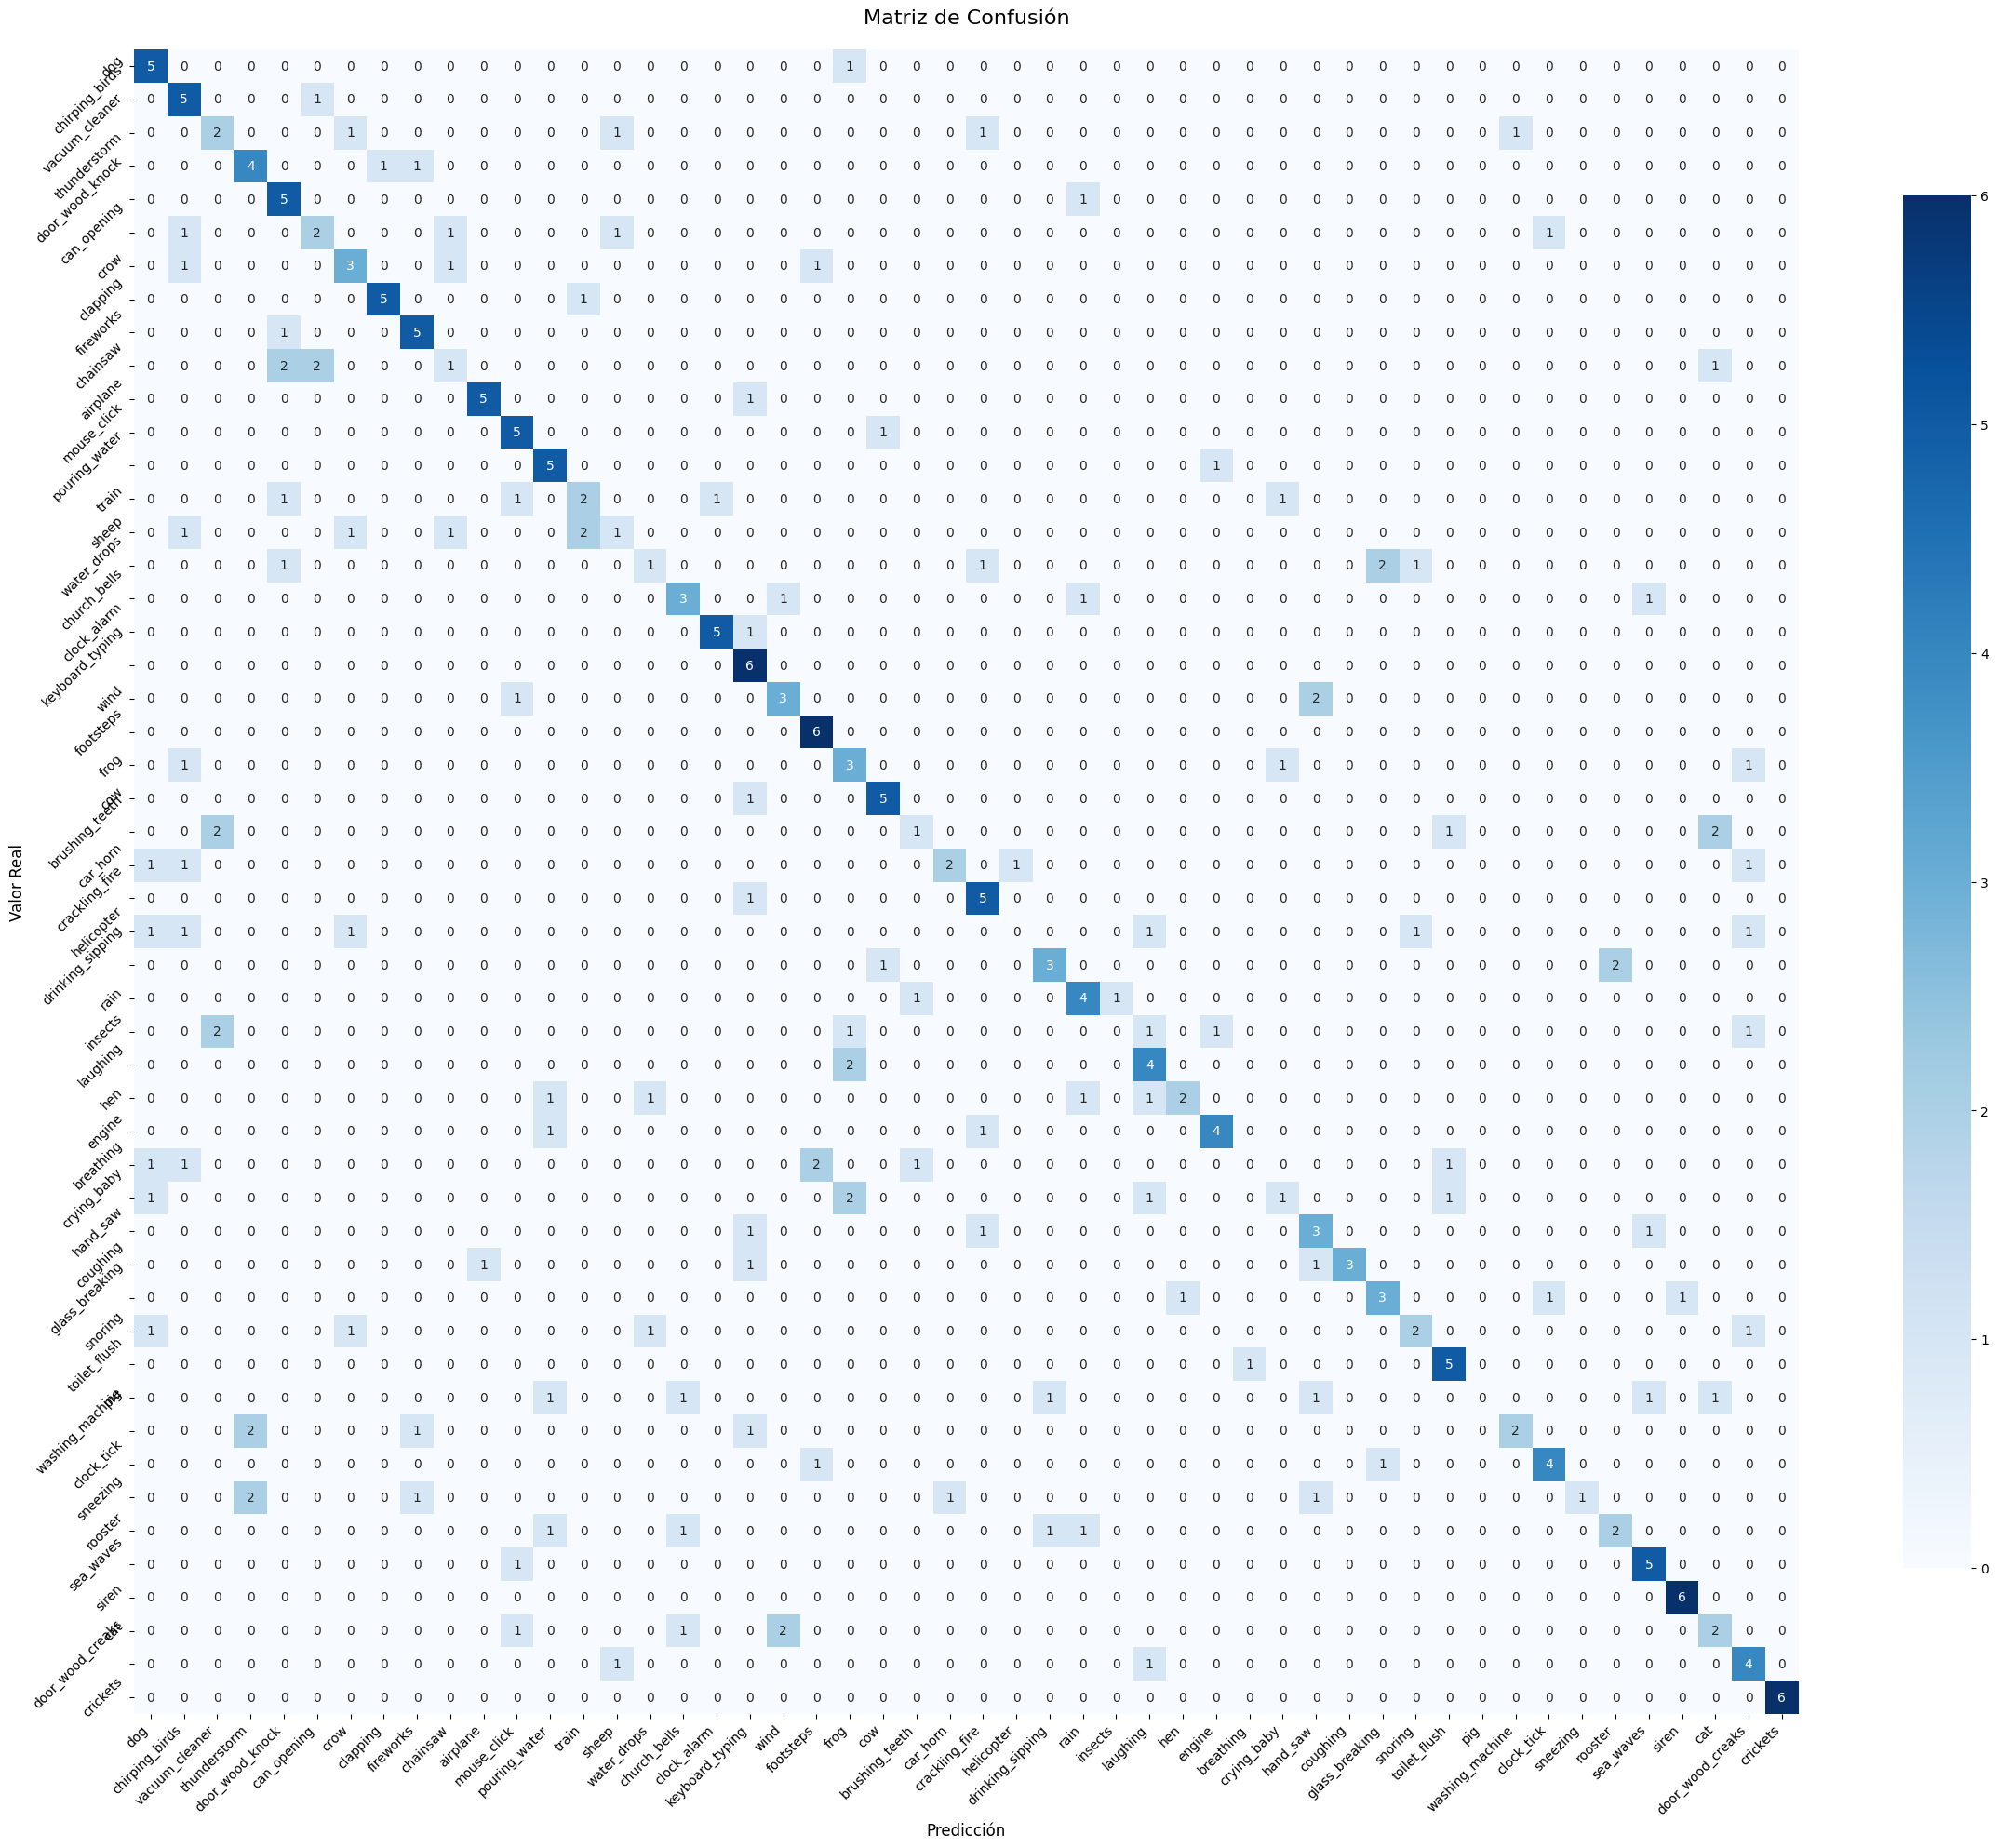


=== REPORTE DE CLASIFICACIÓN DETALLADO ===

Mejores 10 clases por F1-Score:
              precision  recall  f1-score  support
crickets          1.000   1.000     1.000      6.0
siren             0.857   1.000     0.923      6.0
clock_alarm       0.833   0.833     0.833      6.0
airplane          0.833   0.833     0.833      6.0
clapping          0.833   0.833     0.833      6.0
cow               0.714   0.833     0.769      6.0
footsteps         0.600   1.000     0.750      6.0
toilet_flush      0.625   0.833     0.714      6.0
sea_waves         0.625   0.833     0.714      6.0
fireworks         0.625   0.833     0.714      6.0

Peores 10 clases por F1-Score:
                precision  recall  f1-score  support
train               0.400   0.333     0.364      6.0
cat                 0.333   0.333     0.333      6.0
vacuum_cleaner      0.333   0.333     0.333      6.0
sneezing            1.000   0.167     0.286      6.0
water_drops         0.333   0.167     0.222      6.0
brushing_tee

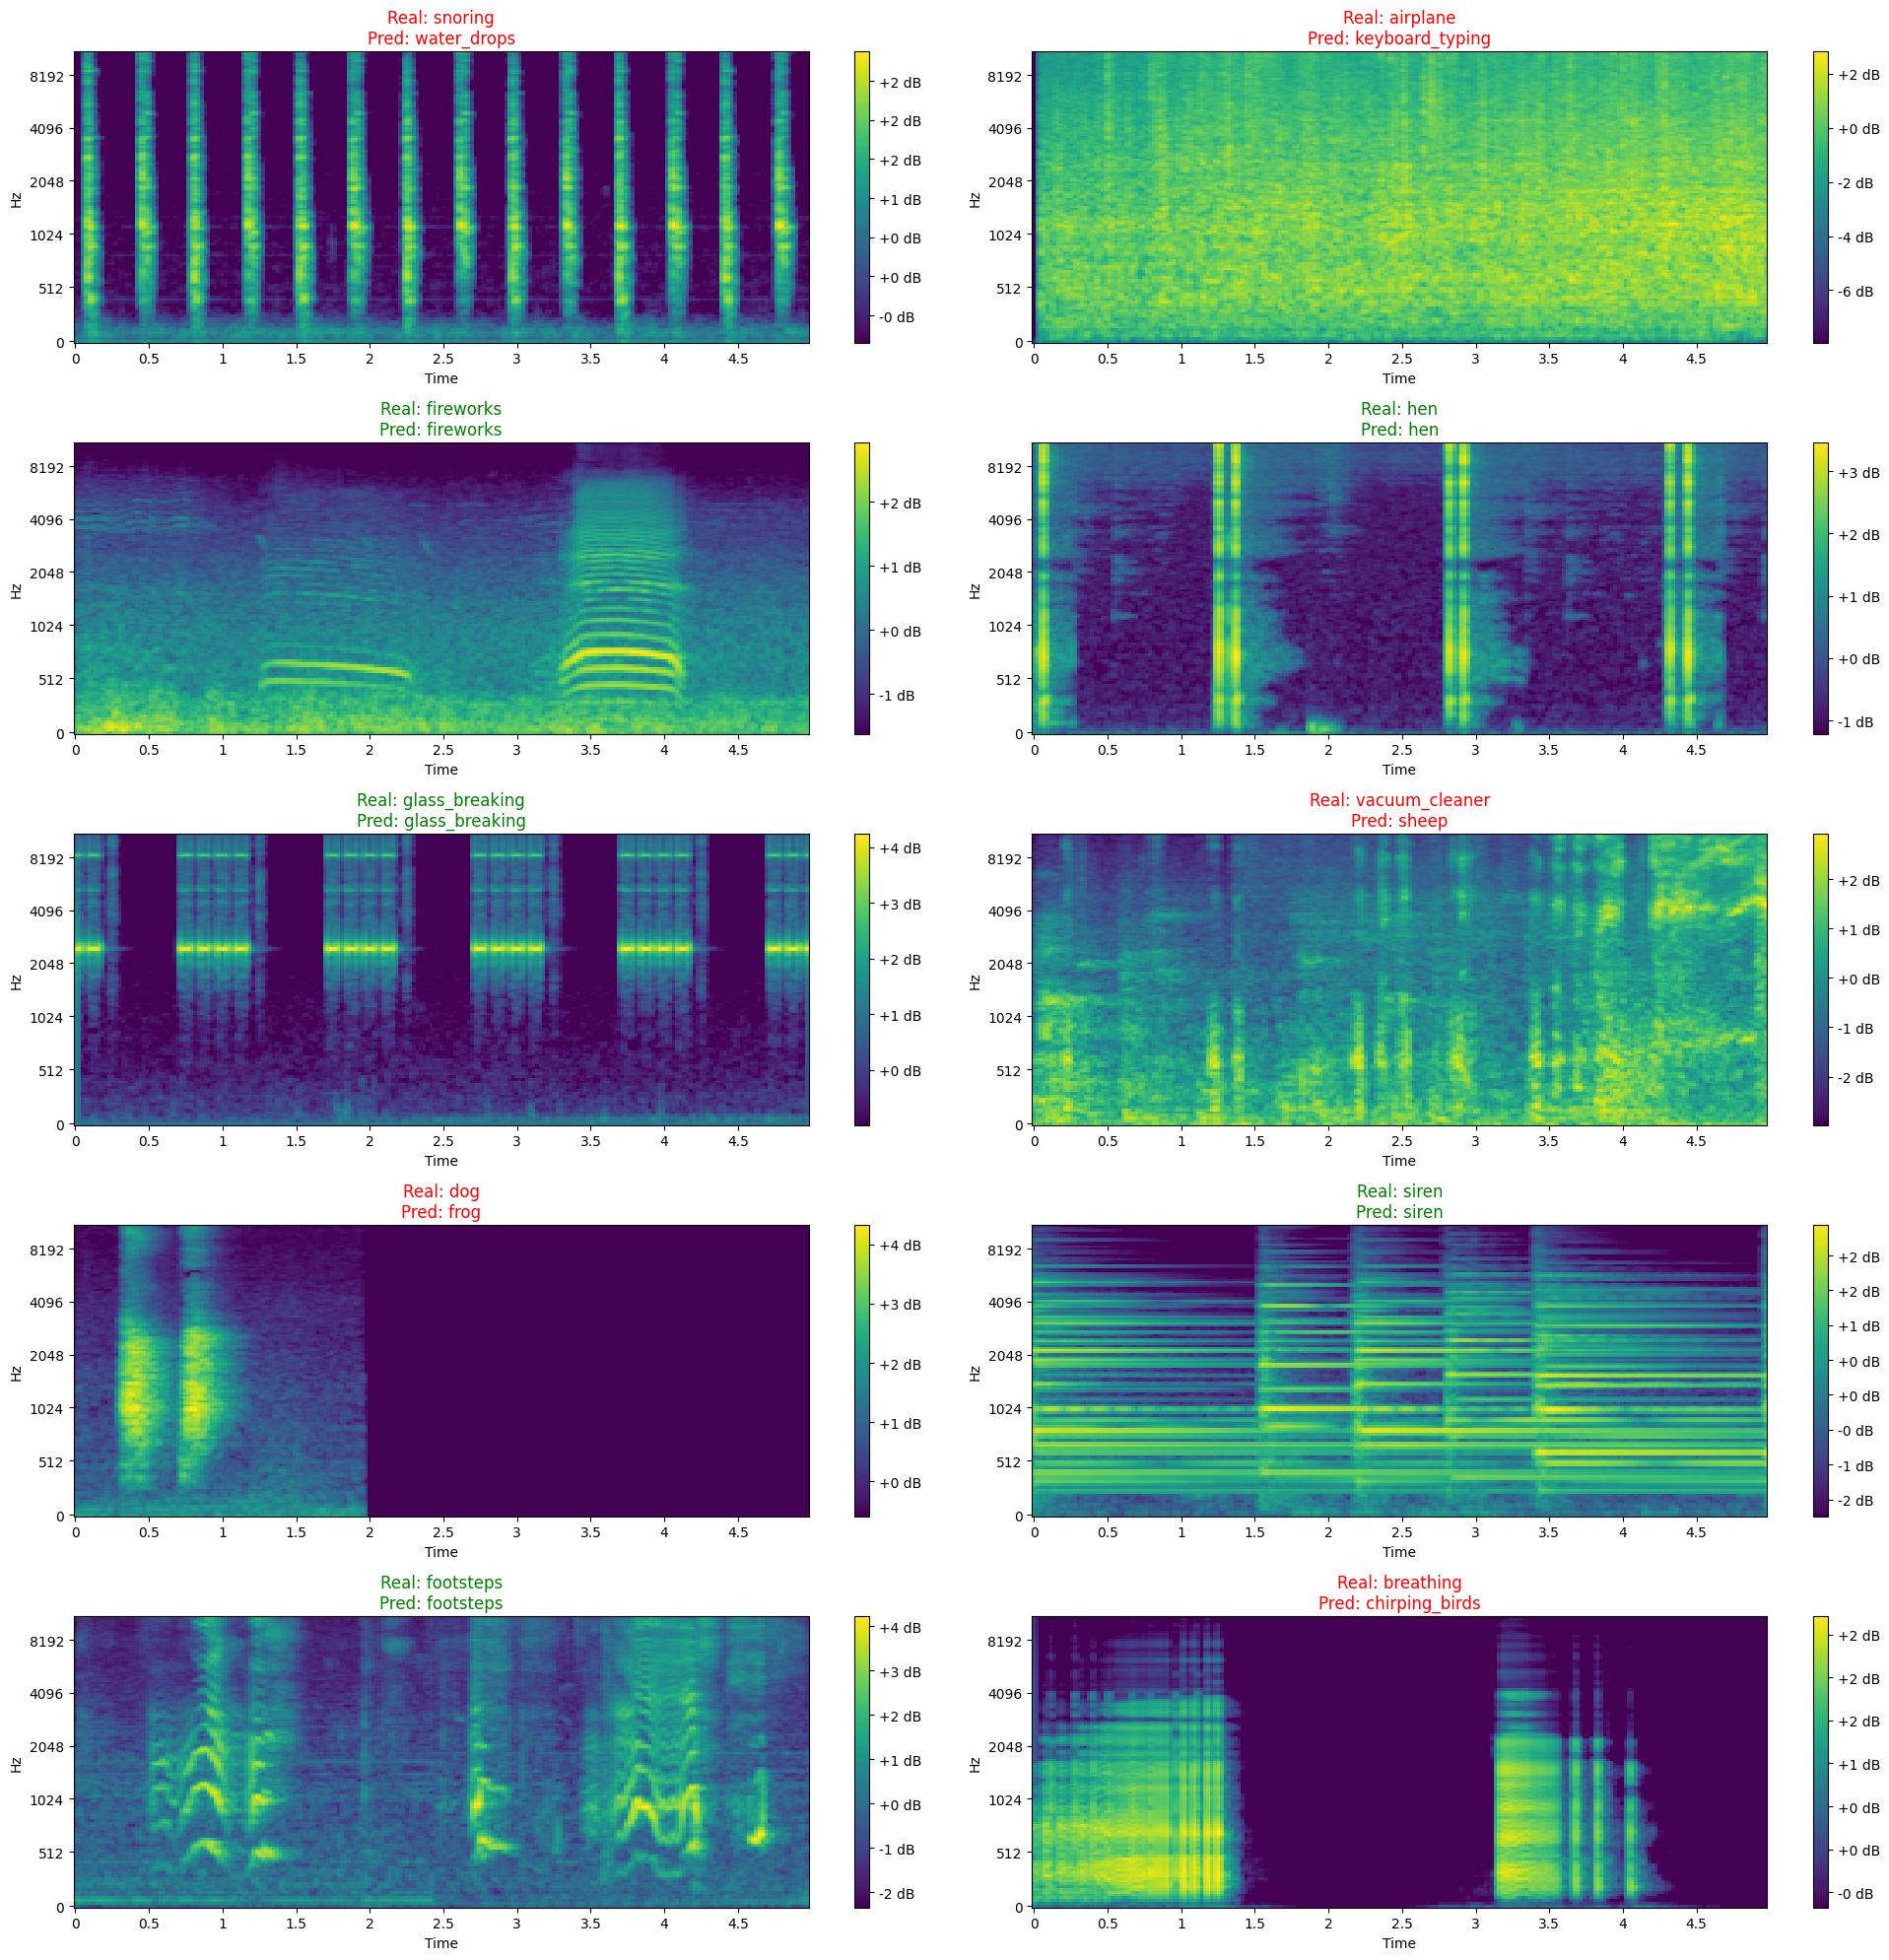


=== PATRONES DE CONFUSIÓN MÁS COMUNES ===

Clase real 'chainsaw' confundida con 'door_wood_knock' 2 veces

Clase real 'chainsaw' confundida con 'can_opening' 2 veces

Clase real 'sheep' confundida con 'train' 2 veces

Clase real 'water_drops' confundida con 'glass_breaking' 2 veces

Clase real 'wind' confundida con 'hand_saw' 2 veces


In [14]:
# Unificación de funciones de evaluación para distintos modelos

def plot_confusion_matrix_fn(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(24, 20))
    sns.heatmap(
        cm, 
        xticklabels=class_names,
        yticklabels=class_names,
        annot=True,
        fmt='d',
        cmap='Blues',
        square=True,
        cbar_kws={"shrink": .8}
    )
    plt.title('Matriz de Confusión', fontsize=16, pad=20)
    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Valor Real', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()


def print_detailed_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, zero_division=0, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_sorted = df_report.sort_values(by='f1-score', ascending=False)
    
    print("\n=== REPORTE DE CLASIFICACIÓN DETALLADO ===")
    print("\nMejores 10 clases por F1-Score:")
    print(df_sorted.head(10).round(3))
    print("\nPeores 10 clases por F1-Score:")
    # Filtramos las últimas 3 filas que suelen ser avg/acc/weight
    print(df_sorted[:-3].tail(10).round(3))
    
    return df_sorted


def visualize_random_predictions(X_data, y_true, y_pred, class_names, num_samples=10):
    """
    Muestra ejemplos aleatorios de predicciones correctas e incorrectas,
    aplanando la última dimensión si es (H, W, 1).
    """
    correct_idx = np.where(y_true == y_pred)[0]
    wrong_idx = np.where(y_true != y_pred)[0]
    
    num_each = num_samples // 2
    selected_correct = random.sample(list(correct_idx), min(num_each, len(correct_idx)))
    selected_wrong = random.sample(list(wrong_idx), min(num_each, len(wrong_idx)))
    selected_idx = selected_correct + selected_wrong
    random.shuffle(selected_idx)
    
    fig = plt.figure(figsize=(20, 4 * ((num_samples + 1) // 2)))
    for i, idx in enumerate(selected_idx):
        # Aplanar si tiene 3D con canal 1
        spectro_2d = X_data[idx]
        if spectro_2d.ndim == 3 and spectro_2d.shape[-1] == 1:
            spectro_2d = spectro_2d[..., 0]
        
        plt.subplot(((num_samples + 1) // 2), 2, i + 1)
        librosa.display.specshow(spectro_2d, x_axis='time', y_axis='mel', cmap='viridis')
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        plt.title(f'Real: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}', color=color)
        plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


def show_confusion_patterns(y_true, y_pred, class_names, top_n=5):
    """Muestra los pares de confusión más frecuentes."""
    cm = confusion_matrix(y_true, y_pred)
    n_classes = len(class_names)
    error_pairs = []
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j:
                error_pairs.append((i, j, cm[i,j]))
    
    error_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\n=== PATRONES DE CONFUSIÓN MÁS COMUNES ===")
    for true_idx, pred_idx, count in error_pairs[:top_n]:
        print(f"\nClase real '{class_names[true_idx]}' confundida con '{class_names[pred_idx]}' {count} veces")


def evaluate_model_results(X_test_data, y_true, y_pred_classes, class_names):
    # (... sin cambios, salvo la llamada a visualize_random_predictions ya incorporada ...)
    plot_confusion_matrix_fn(y_true, y_pred_classes, class_names)
    report_df = print_detailed_classification_report(y_true, y_pred_classes, class_names)
    visualize_random_predictions(X_test_data, y_true, y_pred_classes, class_names, num_samples=10)
    show_confusion_patterns(y_true, y_pred_classes, class_names)
    return report_df
    
# Predicciones y evaluación para el modelo 'propio'
y_pred = model_propio.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = metadata['category'].unique()  # Lista de nombres de clase
report_df = evaluate_model_results(X_test, y_test, y_pred_classes, class_names)


## Visualizacion de errores comunes

Errores encontrados: 139


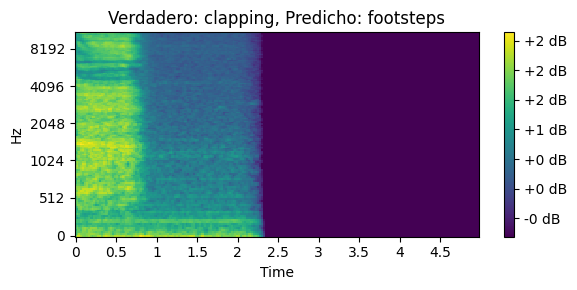

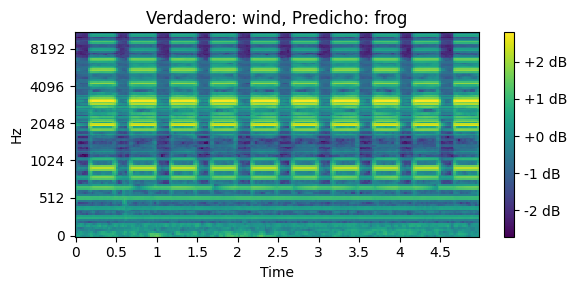

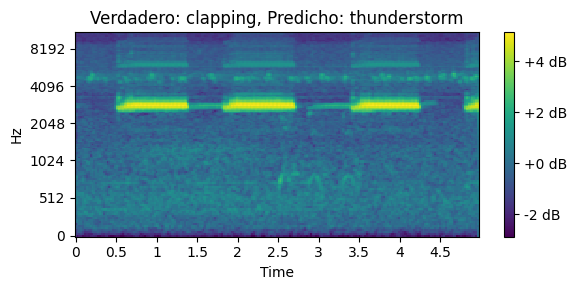

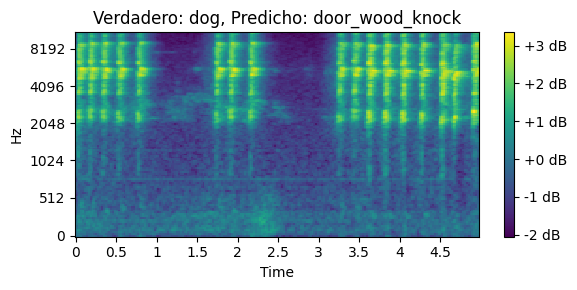

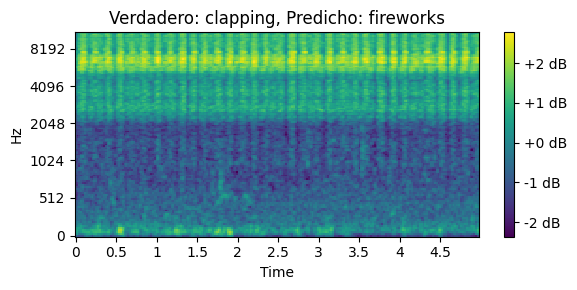

In [15]:
def mostrar_ejemplo(indice, X_data, y_true, y_pred, metadata):
    spectrogram = X_data[indice]
    plt.figure(figsize=(6, 3))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Verdadero: {metadata['category'][y_true[indice]]}, Predicho: {metadata['category'][y_pred[indice]]}")
    plt.tight_layout()
    plt.show()

errores = np.where(y_test != y_pred_classes)[0]
print(f"Errores encontrados: {len(errores)}")

for i in errores[:5]:  # Mostrar los primeros 5 errores
    mostrar_ejemplo(i, X_test, y_test, y_pred_classes, metadata)


## **Resumen resultados del modelo propio**

El modelo propio basado en CNN fue diseñado para trabajar con espectrogramas de Mel generados a partir del dataset ESC-50. A continuación, se presentan las métricas y resultados más destacados:

* **Precisión en Entrenamiento:** Alcanzó un valor máximo de 96% en las últimas épocas.
* **Precisión en Validación:** Fluctuó alrededor del 69%, estabilizándose tras la época 10, pero con una brecha significativa respecto al entrenamiento, lo que indica un nivel de sobreajuste.
* **Pérdida Final:** Aproximadamente 0.8 en validación.
* **Matriz de Confusión:** Las clases con mayor confusión fueron "lluvia" y "olas", así como "viento" y "hojas crujientes".
* **Optimización:** Se usó Adam con una tasa de aprendizaje fija inicial de 0.001.
* **Técnicas de Regularización:** Dropout (0.3 y 0.2) y L2 con valor 0.001.
* **Propuestas de Mejora:** Data augmentation más robusto y estrategias dinámicas de tasa de aprendizaje podrían mitigar el sobreajuste.

## **Modelo VGGish Transfer Learning**

### Preparación de los Datos de Entrada

En esta celda, preprocesamos los datos de entrada (espectrogramas). Esto incluye redimensionar las imágenes a las dimensiones esperadas por VGGish `(96, 64)` y normalizar los valores entre 0 y 1.

In [16]:
# Parámetros de audio optimizados para VGGish
AUDIO_PARAMS_VGGISH = {
    'sr': 16000,  
    'duration': 2.56,  
    'n_mels': 64,  
    'n_fft': 400,  
    'hop_length': 160,
    'fmax': 8000
}

def audio_to_vggish(file_path, augment=False):
    """Generar espectrograma mel adaptado para VGGish."""
    try:
        y, sr = librosa.load(file_path, sr=AUDIO_PARAMS_VGGISH['sr'], duration=AUDIO_PARAMS_VGGISH['duration'])
        
        target_length = int(AUDIO_PARAMS_VGGISH['sr'] * AUDIO_PARAMS_VGGISH['duration'])
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)), mode='constant')
        else:
            y = y[:target_length]
        
        y = librosa.util.normalize(y)
        
        if augment:
            if np.random.random() < 0.5:
                y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))
            if np.random.random() < 0.5:
                y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.95, 1.05))
        
        spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=AUDIO_PARAMS_VGGISH['n_fft'],
            hop_length=AUDIO_PARAMS_VGGISH['hop_length'],
            n_mels=AUDIO_PARAMS_VGGISH['n_mels'],
            fmax=AUDIO_PARAMS_VGGISH['fmax']
        )
        
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
        max_frames = 96  
        current_frames = spectrogram_db.shape[1]
        
        if current_frames > max_frames:
            spectrogram_db = spectrogram_db[:, :max_frames]
        elif current_frames < max_frames:
            pad_width = max_frames - current_frames
            spectrogram_db = np.pad(spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')
        
        spectrogram_norm = (spectrogram_db - np.mean(spectrogram_db)) / (np.std(spectrogram_db) + 1e-6)
        spectrogram_norm = spectrogram_norm[..., np.newaxis]
        
        return spectrogram_norm

    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None


Procesando 2000 archivos para VGGish...


Procesando archivos para VGGish: 100%|██████████| 2000/2000 [00:25<00:00, 77.78archivo/s]


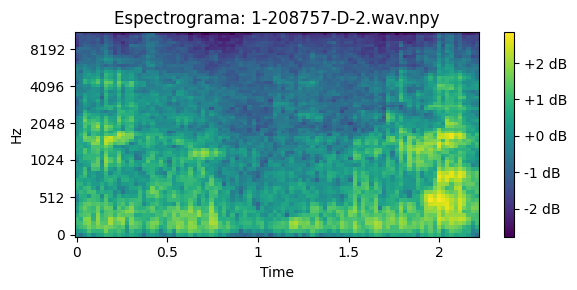

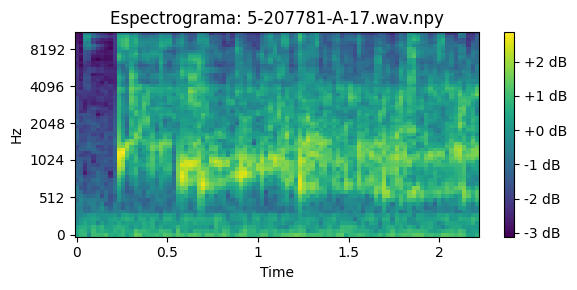

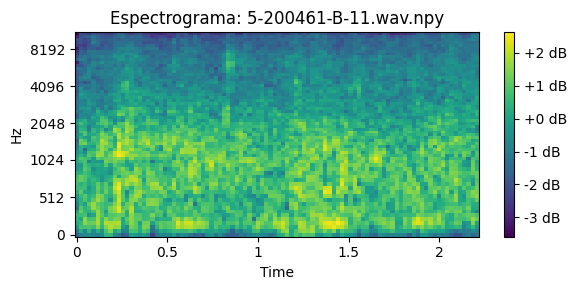

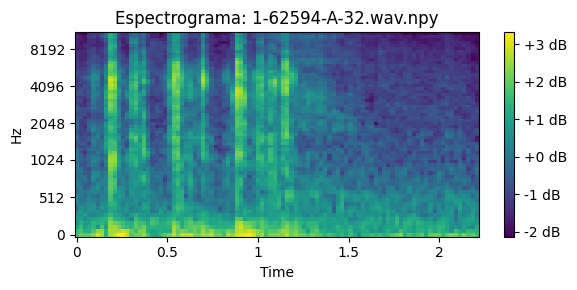

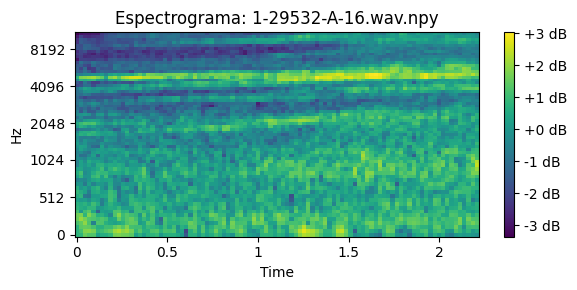

In [17]:
vggish_audio_path = audio_path
vggish_output_path = '/kaggle/working/spectrograms/vggish'
os.makedirs(vggish_output_path, exist_ok=True)

vggish_files = [f for f in os.listdir(vggish_audio_path) if f.endswith('.wav')]

def process_and_save_vggish(file_name):
    file_path = os.path.join(vggish_audio_path, file_name)
    try:
        spectrogram = audio_to_vggish(file_path)
        if spectrogram is not None:
            np.save(os.path.join(vggish_output_path, f"{file_name}.npy"), spectrogram)
    except Exception as e:
        print(f"Error con {file_name}: {e}")

print(f"Procesando {len(vggish_files)} archivos para VGGish...")
for file_name in tqdm(vggish_files, desc="Procesando archivos para VGGish", unit="archivo"):
    process_and_save_vggish(file_name)

vggish_spectrogram_files = [f for f in os.listdir(vggish_output_path) if f.endswith('.npy')]
for spectrogram_file in vggish_spectrogram_files[:5]:
    muestra_espectrograma(os.path.join(vggish_output_path, spectrogram_file))

# Redimensionamos nuestros espectrogramas originales para simular compatibilidad con VGGish
X_train_transfer = np.array([cv2.resize(img, (64, 96)) for img in X_train])  
X_train_transfer = np.expand_dims(X_train_transfer, axis=-1)

X_val_transfer = np.array([cv2.resize(img, (64, 96)) for img in X_val])
X_val_transfer = np.expand_dims(X_val_transfer, axis=-1)

X_test_transfer = np.array([cv2.resize(img, (64, 96)) for img in X_test])
X_test_transfer = np.expand_dims(X_test_transfer, axis=-1)


### Construcción de la Arquitectura Base de VGGish

La arquitectura de VGGish no está incluida directamente en TensorFlow, por lo que se reconstruye manualmente basada en la definición oficial. Esto permite cargar los pesos preentrenados en un modelo equivalente. La esencia del transfer learning está en el uso de los pesos preentrenados, mientras que la arquitectura es un requisito técnico adicional.

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten
import h5py

def build_vggish_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Bloque 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(x)
    
    # Bloque 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(x)
    
    # Bloque 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(x)
    
    # Bloque 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    
    return Model(inputs, x, name='VGGish')

weights_path = '/kaggle/input/vggish/keras/default/1/vggish_audioset_weights_without_fc2.h5'
with h5py.File(weights_path, 'r') as f:
    print(list(f.keys()))


['conv1', 'conv2', 'conv3', 'conv4', 'input_1', 'pool1', 'pool2', 'pool3', 'pool4']


### Carga de los Pesos Preentrenados

En esta celda, cargamos los pesos preentrenados de VGGish. Estos pesos encapsulan conocimiento adquirido previamente en tareas relacionadas con audio y son el núcleo del transfer learning.

In [19]:
base_model_vggish = build_vggish_model((96, 64, 1))
base_model_vggish.load_weights('/kaggle/input/vggish/keras/default/1/vggish_audioset_weights_without_fc2.h5')


### Añadir Capas Superiores Personalizadas

Agregamos las capas superiores necesarias para la tarea específica de clasificación de audio, ajustando la salida a 50 clases.

In [20]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

x = base_model_vggish.output
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(50, activation='softmax')(x)

model_vggish = Model(inputs=base_model_vggish.input, outputs=x)


### Congelar las Capas Base y Compilar el Modelo

Inicialmente, congelamos las capas base para entrenar solo las capas superiores personalizadas. Esto asegura que los pesos preentrenados no se modifiquen al principio.

In [21]:
# Entrenar el modelo completo antes de la evaluación cruzada
for layer in base_model_vggish.layers:
    layer.trainable = False

model_vggish.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Entrenamiento normal del modelo
history_vggish = model_vggish.fit(
    X_train_transfer, y_train_one_hot,
    validation_data=(X_val_transfer, y_val_one_hot),
    epochs=20,
    batch_size=32
)

# Cross-validation en el conjunto de prueba
def cross_validate_on_test(X_test, y_test, model, folds=5):
    """
    Realiza validación cruzada sobre el conjunto de prueba con el modelo entrenado.
    """
    kfold = KFold(n_splits=folds, shuffle=True, random_state=42)
    cv_scores = []

    for fold_idx, (test_idx, val_idx) in enumerate(kfold.split(X_test)):
        print(f"[CV-Test] Fold {fold_idx + 1}/{folds}...")

        # Dividir el conjunto de prueba en particiones para validación cruzada
        X_fold_test, X_fold_val = X_test[test_idx], X_test[val_idx]
        y_fold_test, y_fold_val = y_test[test_idx], y_test[val_idx]

        # Evaluar el modelo en la partición actual
        loss, acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        cv_scores.append(acc)
        print(f"[CV-Test] Fold {fold_idx + 1} finalizó con val_accuracy={acc:.4f}\n")

    print(f"[CV-Test] Accuracies en cada fold: {cv_scores}")
    print(f"[CV-Test] Accuracy promedio: {np.mean(cv_scores):.4f}")
    return cv_scores

# Ejecutar CV en el conjunto de prueba
cv_scores_vggish_test = cross_validate_on_test(X_test_transfer, y_test_one_hot, model_vggish, folds=5)

print(f"[CV-Test] Promedio de accuracy en cross-validation (VGGish, conjunto de prueba): {np.mean(cv_scores_vggish_test):.4f}")


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.0259 - loss: 5.5803 - val_accuracy: 0.0200 - val_loss: 3.8955
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0983 - loss: 4.3061 - val_accuracy: 0.0200 - val_loss: 3.8872
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1598 - loss: 3.5867 - val_accuracy: 0.0233 - val_loss: 3.8643
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2399 - loss: 3.1958 - val_accuracy: 0.0233 - val_loss: 3.8184
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3089 - loss: 2.7367 - val_accuracy: 0.0600 - val_loss: 3.7280
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3451 - loss: 2.5369 - val_accuracy: 0.0867 - val_loss: 3.6051
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4072 - loss: 2.2335 - val_accuracy: 0.1500 - val_loss: 3.4549
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4613 - loss: 2.0781 - val_accuracy: 0.2300 - val_lo

### Fine-Tuning

Descongelamos las últimas 10 capas del modelo base para realizar un ajuste fino (fine-tuning), permitiendo que el modelo adapte los pesos preentrenados a la tarea actual.

In [22]:
# Descongelar las últimas 10 capas del modelo base para fine-tuning
for layer in base_model_vggish.layers[-10:]:
    layer.trainable = True

# Compilar el modelo con una tasa de aprendizaje más baja para fine-tuning
model_vggish.compile(optimizer=Adam(learning_rate=1e-6),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Entrenamiento normal del modelo
history_finetune_vggish = model_vggish.fit(
    X_train_transfer, y_train_one_hot,
    validation_data=(X_val_transfer, y_val_one_hot),
    epochs=20,
    batch_size=32
)

# Reutilizar la función cross_validate_on_test para el conjunto de prueba
cv_scores_vggish_ft_test = cross_validate_on_test(X_test_transfer, y_test_one_hot, model_vggish, folds=5)

print(f"[CV-Test] Promedio de accuracy en cross-validation (VGGish fine-tune, conjunto de prueba): {np.mean(cv_scores_vggish_ft_test):.4f}")


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.8203 - loss: 0.7408 - val_accuracy: 0.5667 - val_loss: 1.6905
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8385 - loss: 0.7024 - val_accuracy: 0.5667 - val_loss: 1.6823
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8204 - loss: 0.7532 - val_accuracy: 0.5633 - val_loss: 1.6744
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8284 - loss: 0.7277 - val_accuracy: 0.5600 - val_loss: 1.6702
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8148 - loss: 0.7243 - val_accuracy: 0.5700 - val_loss: 1.6678
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8343 - loss: 0.7253 - val_accuracy: 0.5667 - val_loss: 1.6668
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8298 - loss: 0.7116 - val_accuracy: 0.5600 - val_loss: 1.6640
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8190 - loss: 0.7068 - val_accuracy: 0.5667 -

### Guardar y Evaluar

Guardamos el modelo entrenado y generamos un resumen gráfico del entrenamiento, incluyendo una matriz de confusión y un informe de clasificación.


In [23]:
model_vggish.save('modelo_finetuned_vggish.keras')

layer_types = {}
for layer in model_vggish.layers:
    layer_type = type(layer).__name__
    layer_types[layer_type] = layer_types.get(layer_type, 0) + 1

print("Resumen compacto del modelo:")
for layer_type, count in layer_types.items():
    print(f"{layer_type}: {count} capas")


Resumen compacto del modelo:
InputLayer: 1 capas
Conv2D: 6 capas
MaxPooling2D: 4 capas
Flatten: 1 capas
Dense: 3 capas
BatchNormalization: 2 capas
Dropout: 2 capas


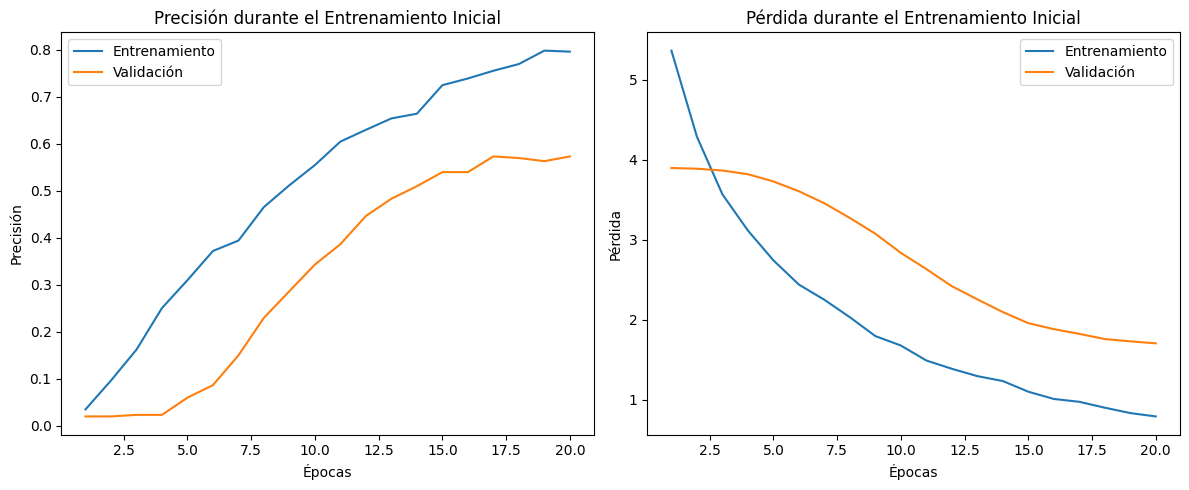

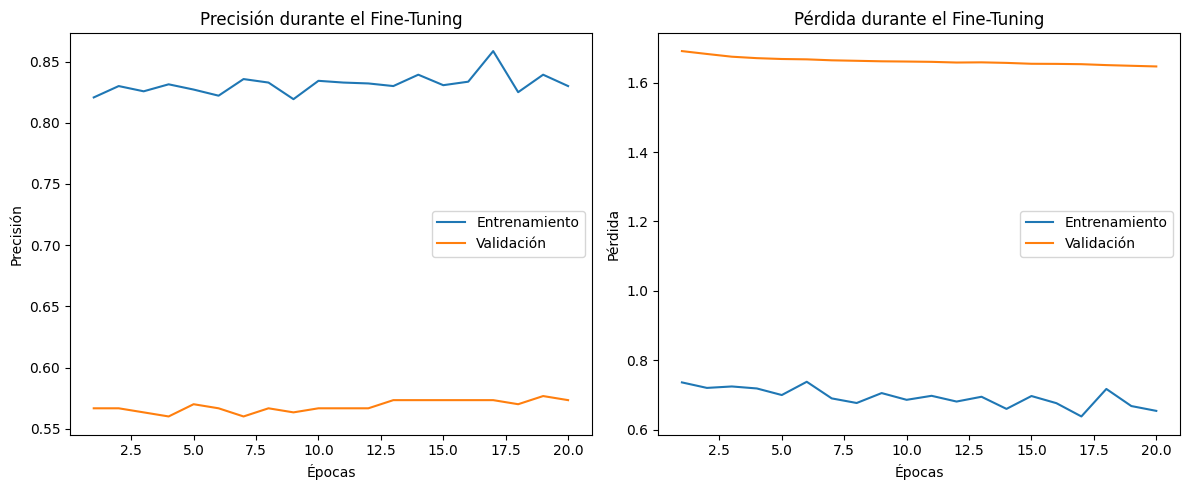

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


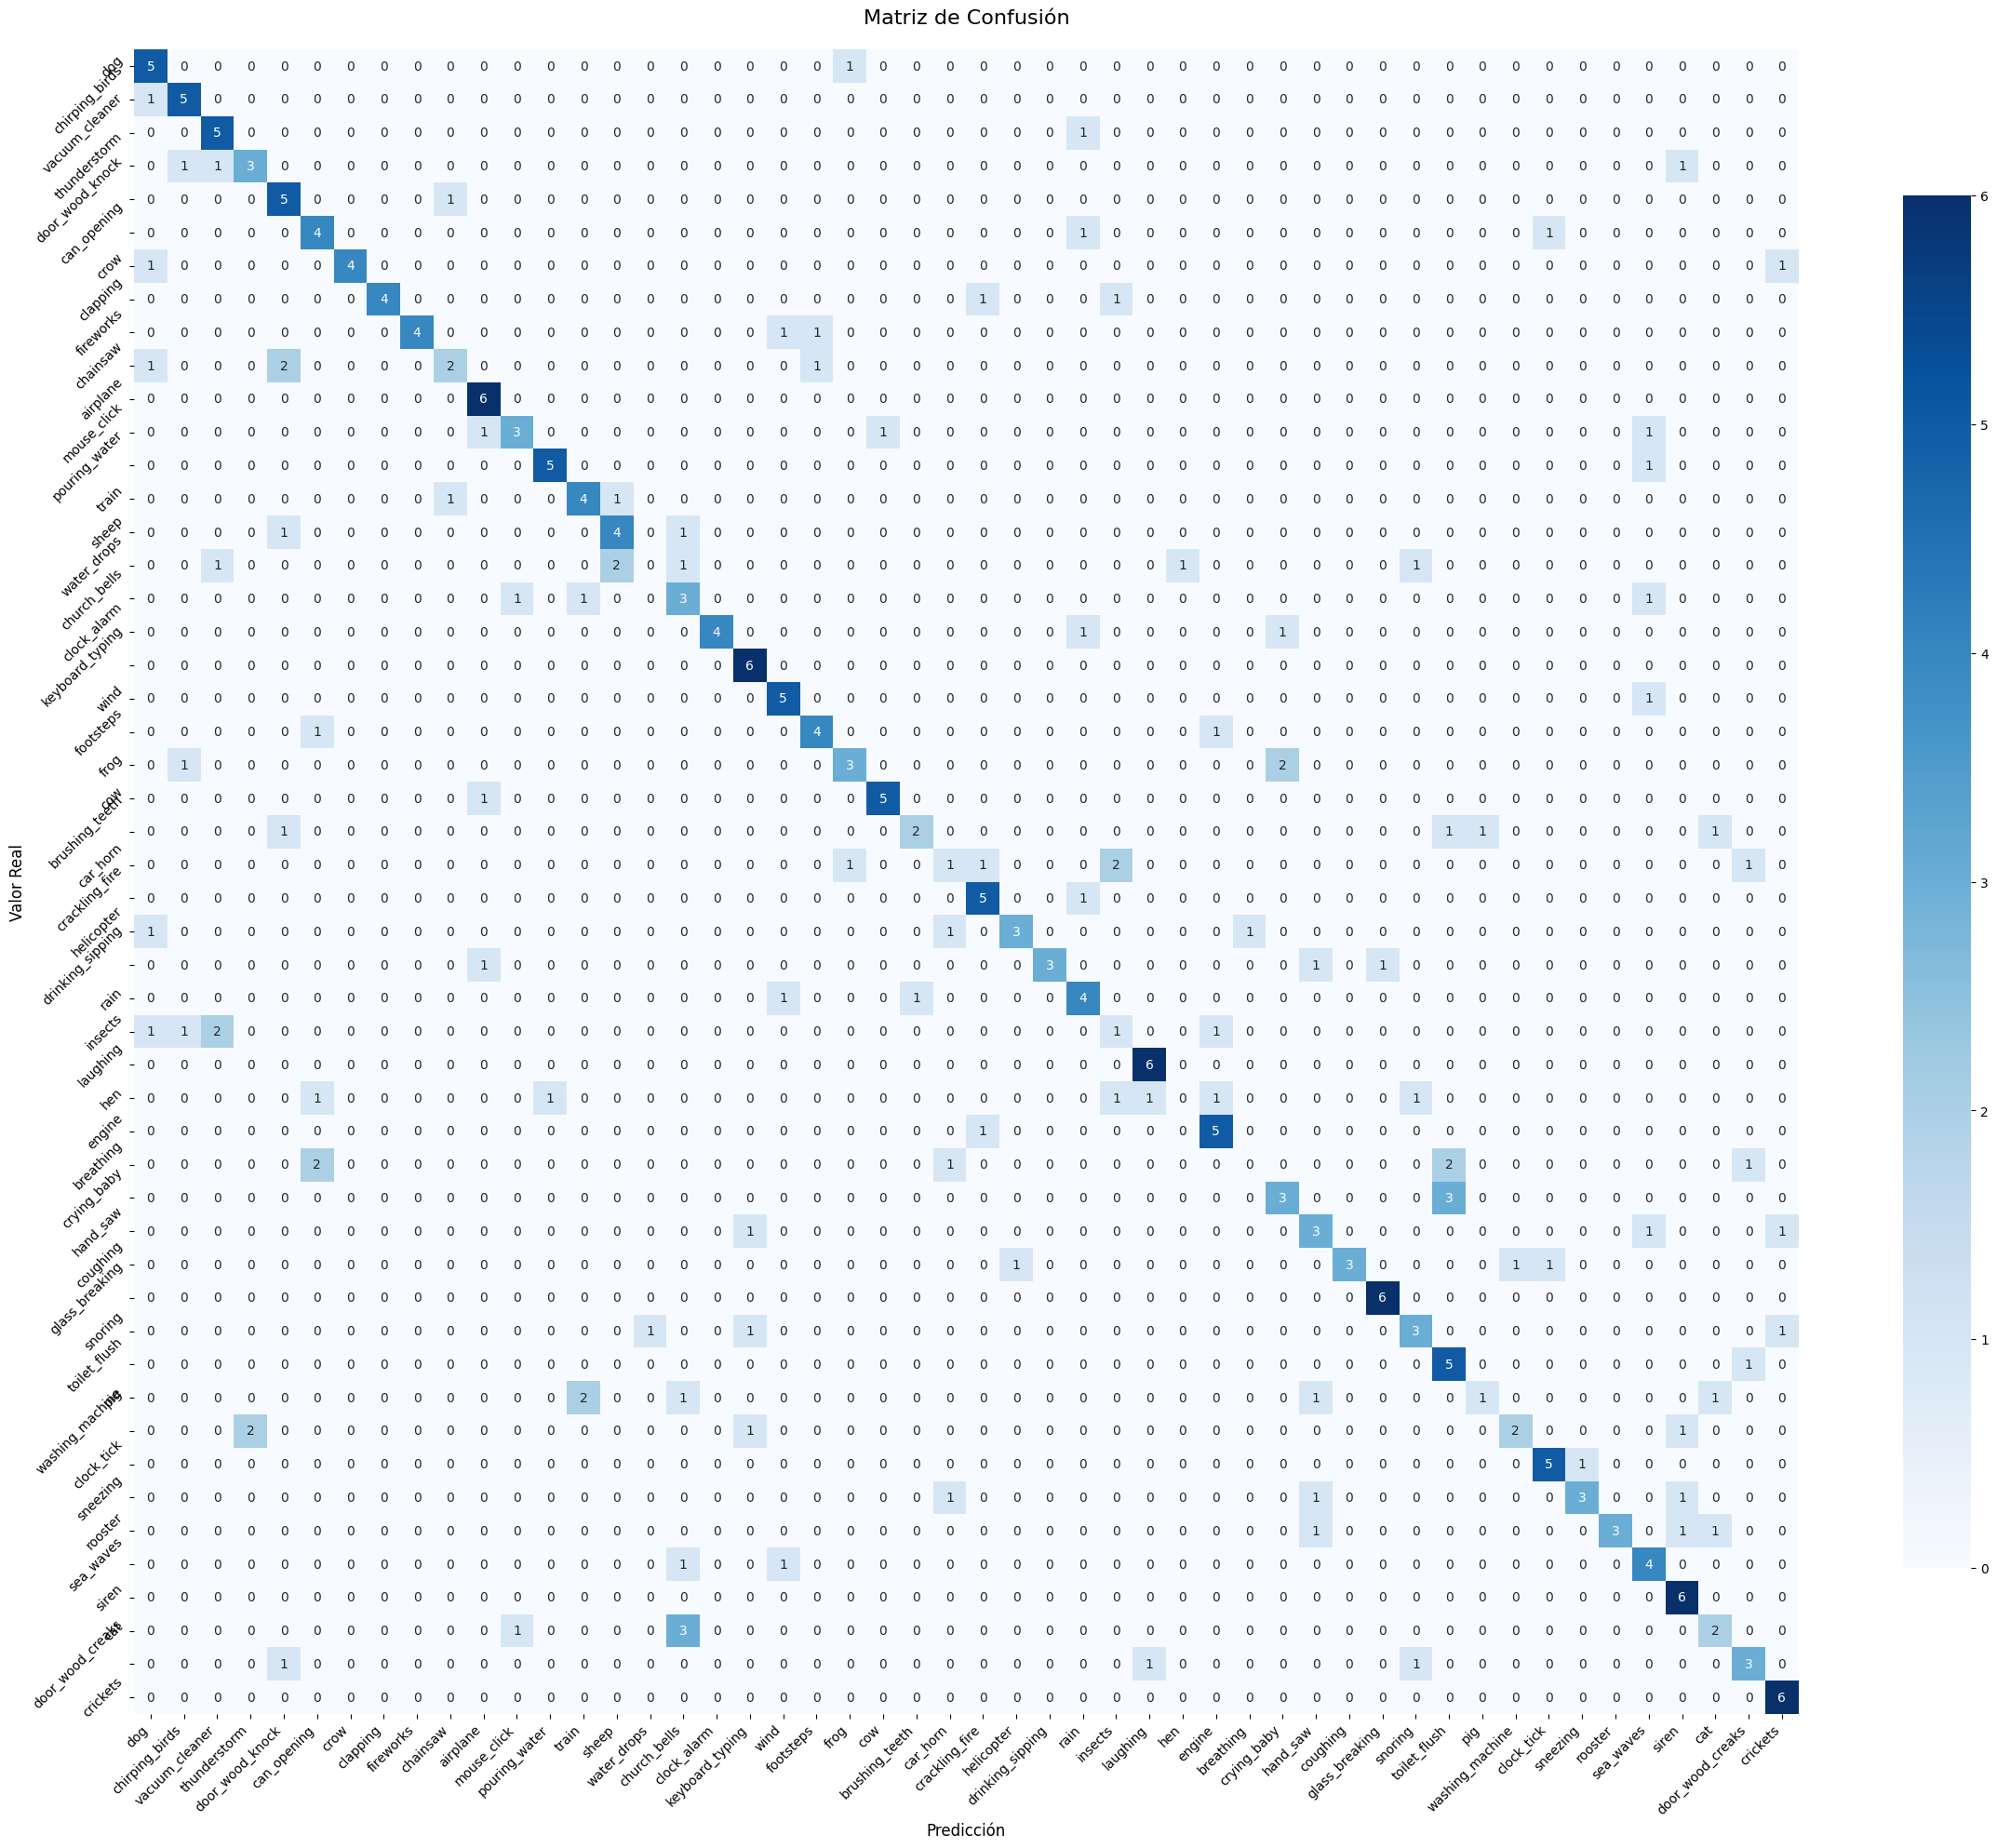


=== REPORTE DE CLASIFICACIÓN DETALLADO ===

Mejores 10 clases por F1-Score:
                 precision  recall  f1-score  support
glass_breaking       0.857   1.000     0.923      6.0
laughing             0.750   1.000     0.857      6.0
cow                  0.833   0.833     0.833      6.0
pouring_water        0.833   0.833     0.833      6.0
clapping             1.000   0.667     0.800      6.0
clock_alarm          1.000   0.667     0.800      6.0
keyboard_typing      0.667   1.000     0.800      6.0
crow                 1.000   0.667     0.800      6.0
airplane             0.667   1.000     0.800      6.0
crickets             0.667   1.000     0.800      6.0

Peores 10 clases por F1-Score:
                 precision  recall  f1-score  support
snoring              0.500   0.500     0.500      6.0
hand_saw             0.429   0.500     0.462      6.0
brushing_teeth       0.667   0.333     0.444      6.0
washing_machine      0.667   0.333     0.444      6.0
chainsaw             0.500 

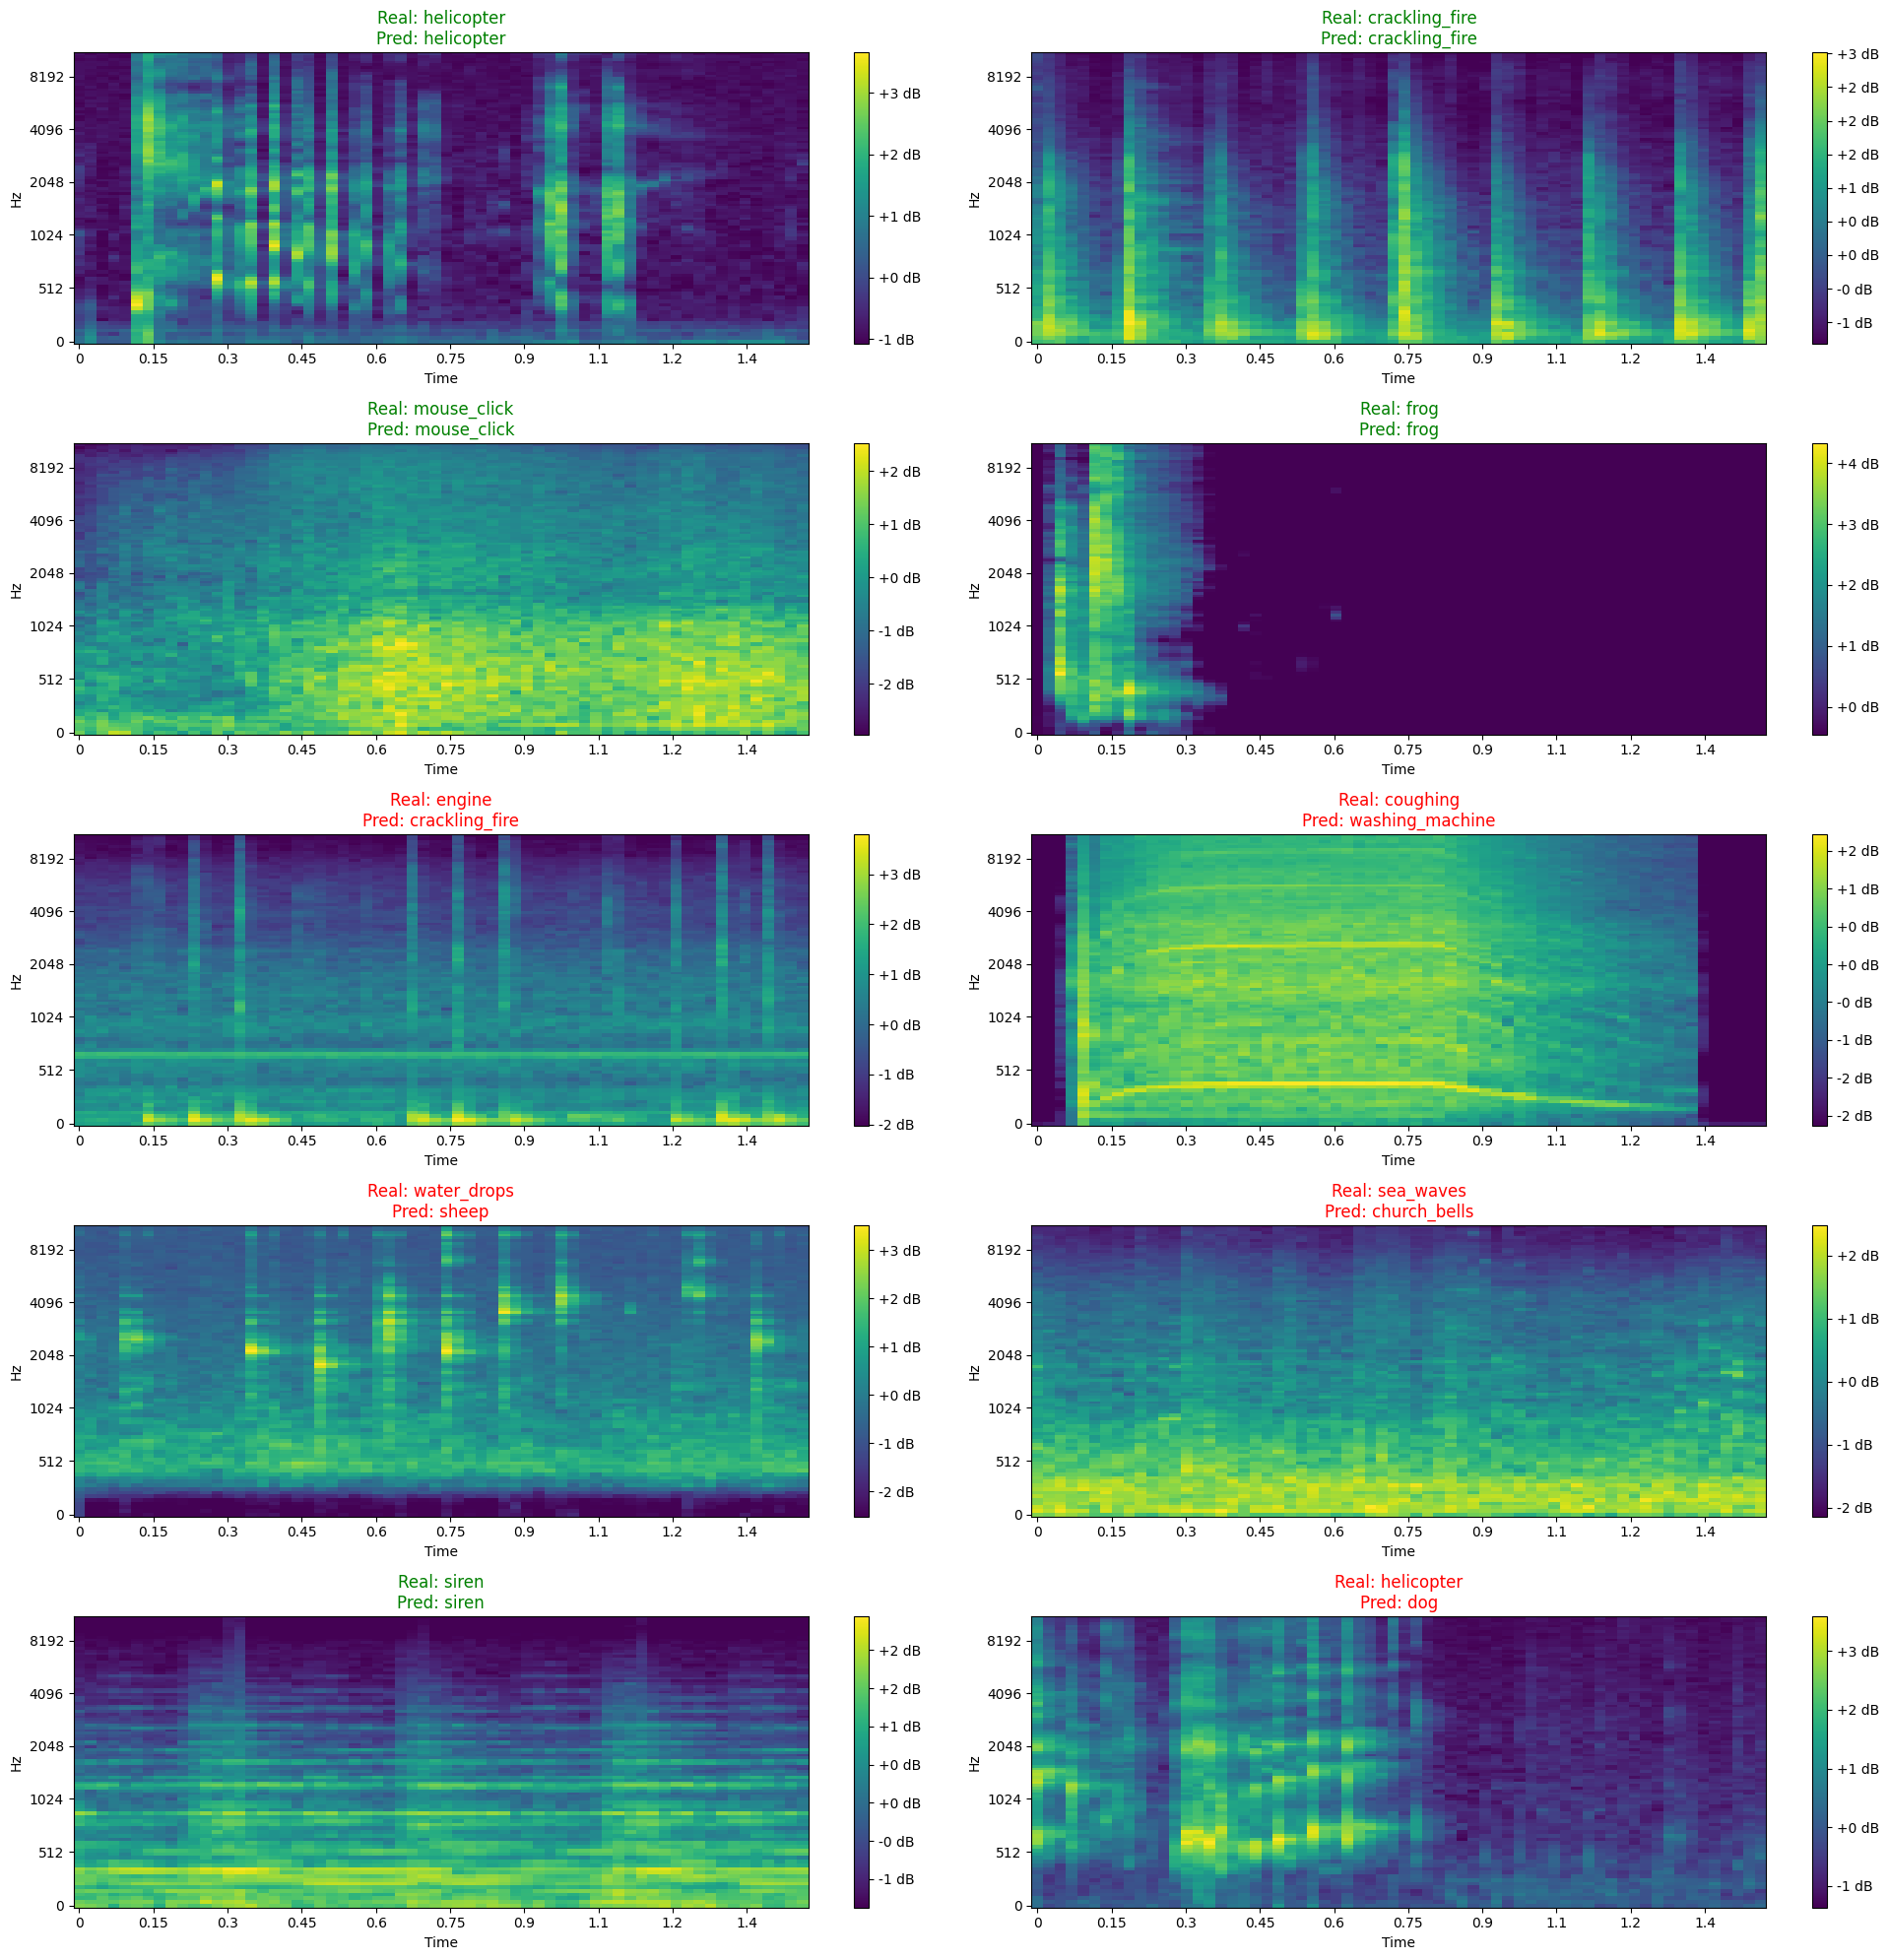


=== PATRONES DE CONFUSIÓN MÁS COMUNES ===

Clase real 'crying_baby' confundida con 'toilet_flush' 3 veces

Clase real 'cat' confundida con 'church_bells' 3 veces

Clase real 'chainsaw' confundida con 'door_wood_knock' 2 veces

Clase real 'water_drops' confundida con 'sheep' 2 veces

Clase real 'frog' confundida con 'crying_baby' 2 veces


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history, title=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Entrenamiento')
    plt.plot(epochs, val_acc, label='Validación')
    plt.title(f'Precisión durante el {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title(f'Pérdida durante el {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_vggish, title="Entrenamiento Inicial")
plot_training_history(history_finetune_vggish, title="Fine-Tuning")

y_pred_vggish = model_vggish.predict(X_test_transfer)
y_pred_vggish_classes = np.argmax(y_pred_vggish, axis=1)
y_true_vggish_classes = np.argmax(y_test_one_hot, axis=1)

report_df_vggish = evaluate_model_results(X_test_transfer, y_true_vggish_classes, y_pred_vggish_classes, class_names)



## **Resumen resultados VGGISH**

## Modelo VGGish

VGGish, un modelo preentrenado en AudioSet, fue adaptado para la tarea utilizando transfer learning:

* **Precisión en Entrenamiento:** 82% en las últimas épocas.
* **Precisión en Validación:** Un promedio de aproximadamente 59% tras validación cruzada.
* **Pérdida Final:** Alrededor de 1.6 en validación.
* **Diferencias Notables:** Superó al modelo propio en varias clases con alta similitud, aunque el rendimiento general se vio afectado por el tamaño del dataset.
* **Eficiencia:** La convergencia fue más rápida en las primeras épocas debido al preentrenamiento.
* **Propuestas de Mejora:** Incrementar el fine-tuning en capas adicionales podría explotar mejor las características preentrenadas.

# Modelo AST (Audio Spectrogram Transformer)

Este notebook implementa y entrena el modelo AST (Audio Spectrogram Transformer). Se procesan datos de audio en espectrogramas Mel y se emplea una arquitectura basada en transformadores para realizar la clasificación.

Las etapas principales son:

1. Preprocesar los datos para adaptarlos al formato de entrada de AST.
2. Definir la arquitectura del modelo AST.
3. Entrenar el modelo con los datos.
4. Evaluar y guardar el modelo entrenado.


## Preprocesamiento de Datos

AST requiere entradas en forma de espectrogramas Mel con las siguientes características:
- Frecuencia de muestreo: 16 kHz
- 128 bandas Mel
- Hop length: 160
- fmax: 8000 Hz
- Dimensiones finales: (128, 128, 1) por espectrograma

En esta sección, se preprocesan los archivos de audio, generando espectrogramas Mel normalizados y aplicando augmentación de datos opcional.


In [25]:
# Librerías y parámetros para preprocesamiento
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

AUDIO_PARAMS_AST = {
    'sr': 16000,
    'n_fft': 400,
    'hop_length': 160,
    'n_mels': 128,
    'fmax': 8000
}

def preprocess_audio_for_ast(file_path):
    """
    Convierte un archivo de audio en un espectrograma Mel compatible con AST.
    Incluye normalización robusta y augmentación de datos opcional.
    """
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

        y, sr = librosa.load(file_path, sr=AUDIO_PARAMS_AST['sr'])

        if np.random.rand() < 0.3:
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))
        if np.random.rand() < 0.3:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.95, 1.05))

        mel_spectrogram = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=AUDIO_PARAMS_AST['n_fft'],
            hop_length=AUDIO_PARAMS_AST['hop_length'],
            n_mels=AUDIO_PARAMS_AST['n_mels'],
            fmax=AUDIO_PARAMS_AST['fmax']
        )

        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = (mel_spectrogram_db - mel_spectrogram_db.mean()) / (mel_spectrogram_db.std() + 1e-6)

        if np.random.rand() > 0.5:
            mel_spectrogram_db += np.random.uniform(-0.1, 0.1, mel_spectrogram_db.shape)
        if np.random.rand() > 0.5:
            mel_spectrogram_db = np.roll(mel_spectrogram_db, np.random.randint(-5, 5), axis=1)

        return mel_spectrogram_db
    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None


## Definición del Modelo AST

En esta sección, definimos el modelo AST utilizando la API funcional de Keras. El modelo incluye:
- Capas convolucionales para embeddings de parches.
- Un codificador Transformer para capturar relaciones entre los parches.
- Capas densas para la clasificación final.


In [26]:
from tensorflow.keras import layers, Input

def build_keras_ast_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(256, kernel_size=(16, 16), strides=(16, 16), padding="same")(inputs)
    x = layers.Reshape((-1, 256))(x)

    for _ in range(12):
        attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=256)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)

        ffn_output = layers.Dense(256, activation="relu")(x)
        ffn_output = layers.Dense(256)(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


## Entrenamiento Inicial del Modelo

Congelamos las capas base del modelo y entrenamos las capas superiores utilizando un optimizador Adam y pérdida de entropía cruzada.


In [27]:
metadata_path = '/kaggle/input/dataset/ESC-50-master/meta/esc50.csv'
audio_path = '/kaggle/input/dataset/ESC-50-master/audio'
metadata = pd.read_csv(metadata_path)

spectrograms = []
labels = []

for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Preprocesando AST"):
    file_path = os.path.join(audio_path, row['filename'])
    label = row['category']

    spectrogram = preprocess_audio_for_ast(file_path)
    if spectrogram is not None:
        spectrogram = spectrogram[:128, :128]
        spectrogram = np.expand_dims(spectrogram, axis=-1)
        spectrograms.append(spectrogram)
        labels.append(label)

class_to_index = {cls: idx for idx, cls in enumerate(metadata['category'].unique())}
numeric_labels = [class_to_index[label] for label in labels]
y_data = to_categorical(numeric_labels, num_classes=50)

X_data = np.array(spectrograms, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

keras_model = build_keras_ast_model((128, 128, 1), num_classes=50)
keras_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = keras_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=32,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
    ]
)


Preprocesando AST: 100%|██████████| 2000/2000 [01:53<00:00, 17.63it/s]


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 616ms/step - accuracy: 0.0167 - loss: 4.9780 - val_accuracy: 0.0425 - val_loss: 3.9184 - learning_rate: 5.0000e-05
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.0256 - loss: 4.3191 - val_accuracy: 0.0700 - val_loss: 3.7844 - learning_rate: 5.0000e-05
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.0379 - loss: 4.1110 - val_accuracy: 0.0825 - val_loss: 3.6934 - learning_rate: 5.0000e-05
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.0560 - loss: 3.8755 - val_accuracy: 0.1075 - val_loss: 3.5697 - learning_rate: 5.0000e-05
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.0776 - loss: 3.6728 - val_accuracy: 0.1400 - val_loss: 3.4170 - learning_rate: 5.0000e-05
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.0869 - loss: 3.6099 - val_accuracy: 0.1400 - val_loss: 3.3251 - learning_rate: 5.0000e-05
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.120

## Cross-Validation en el Conjunto de Prueba

Validamos el modelo ya entrenado en el conjunto de prueba utilizando validación cruzada para obtener una evaluación robusta.


In [28]:
from sklearn.model_selection import KFold

def cross_validate_on_test(X_test, y_test, model, folds=5):
    kfold = KFold(n_splits=folds, shuffle=True, random_state=42)
    cv_scores = []

    for fold_idx, (test_idx, val_idx) in enumerate(kfold.split(X_test)):
        print(f"[CV-Test] Fold {fold_idx + 1}/{folds}...")

        X_fold_test, X_fold_val = X_test[test_idx], X_test[val_idx]
        y_fold_test, y_fold_val = y_test[test_idx], y_test[val_idx]

        loss, acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        cv_scores.append(acc)
        print(f"[CV-Test] Fold {fold_idx + 1} finalizó con val_accuracy={acc:.4f}\n")

    print(f"[CV-Test] Accuracies en cada fold: {cv_scores}")
    print(f"[CV-Test] Accuracy promedio: {np.mean(cv_scores):.4f}")
    return cv_scores

cv_test_scores = cross_validate_on_test(X_test, y_test, keras_model, folds=5)


[CV-Test] Fold 1/5...
[CV-Test] Fold 1 finalizó con val_accuracy=0.3625

[CV-Test] Fold 2/5...
[CV-Test] Fold 2 finalizó con val_accuracy=0.2750

[CV-Test] Fold 3/5...
[CV-Test] Fold 3 finalizó con val_accuracy=0.2500

[CV-Test] Fold 4/5...
[CV-Test] Fold 4 finalizó con val_accuracy=0.3500

[CV-Test] Fold 5/5...
[CV-Test] Fold 5 finalizó con val_accuracy=0.4375

[CV-Test] Accuracies en cada fold: [0.36250001192092896, 0.2750000059604645, 0.25, 0.3499999940395355, 0.4375]
[CV-Test] Accuracy promedio: 0.3350


## Evaluación del Modelo AST

Generamos métricas de evaluación más detalladas, incluyendo matriz de confusión, reporte de clasificación y visualización de predicciones.


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step


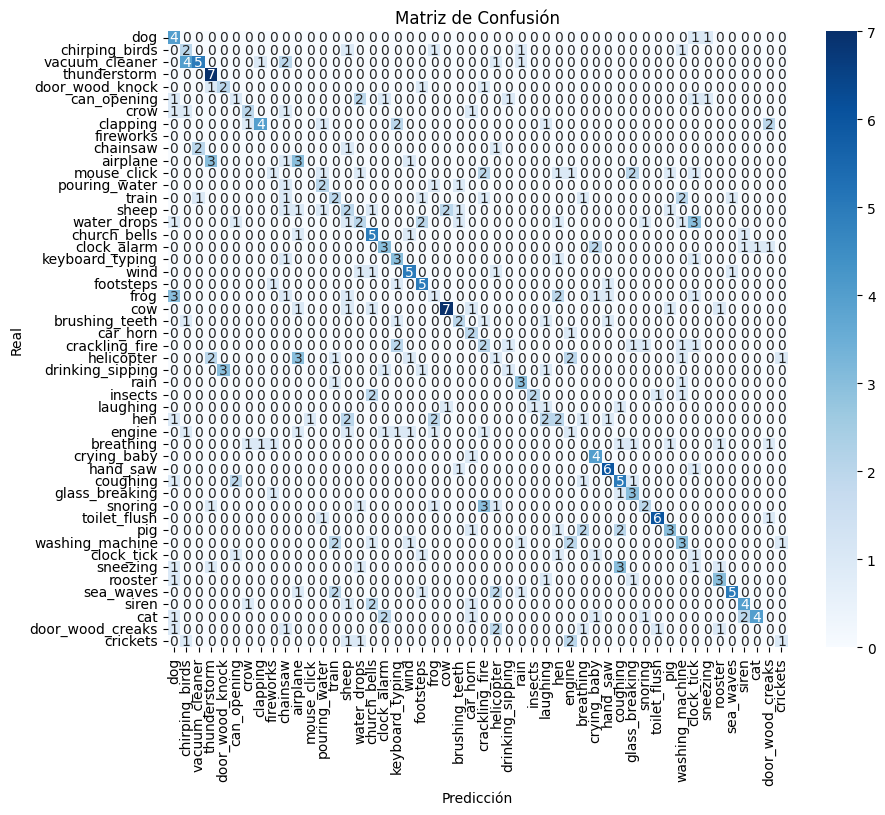

Reporte de Clasificación:
                  precision    recall  f1-score   support

             dog       0.25      0.67      0.36         6
  chirping_birds       0.20      0.33      0.25         6
  vacuum_cleaner       0.62      0.36      0.45        14
    thunderstorm       0.47      1.00      0.64         7
 door_wood_knock       0.40      0.40      0.40         5
     can_opening       0.20      0.12      0.15         8
            crow       0.40      0.33      0.36         6
        clapping       0.67      0.36      0.47        11
       fireworks       0.00      0.00      0.00         0
        chainsaw       0.00      0.00      0.00         4
        airplane       0.27      0.38      0.32         8
     mouse_click       0.00      0.00      0.00        11
   pouring_water       0.33      0.40      0.36         5
           train       0.25      0.20      0.22        10
           sheep       0.17      0.20      0.18        10
     water_drops       0.22      0.14      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_results(X_test_data, y_true, y_pred_classes, class_names):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

    print("Reporte de Clasificación:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    return cm

y_pred = np.argmax(keras_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
class_names = metadata['category'].unique()

cm = evaluate_model_results(X_test, y_true, y_pred, class_names)


## Guardar el Modelo Entrenado

Guardamos el modelo entrenado para reutilización futura.


In [30]:
keras_model.save('/kaggle/working/ast_finetuned_keras.keras', save_format="keras")
print("Modelo AST guardado como 'ast_finetuned_keras.keras'.")


Modelo AST guardado como 'ast_finetuned_keras.keras'.


## **Resumen resultados AST**

## Modelo AST (Audio Spectrogram Transformer)

El modelo AST, basado en Transformers, fue diseñado específicamente para espectrogramas:

* **Precisión en Entrenamiento:** Alrededor del 77% tras 40 épocas.
* **Precisión en Validación:** Reportó un máximo promedio de aproximadamente 38% tras validación cruzada, reflejando limitaciones en generalización.
* **Pérdida Final:** Alrededor de 2.4 en validación, indicando problemas de ajuste.
* **Ventajas Notables:** Captura eficiente de relaciones temporales y frecuenciales, pero afectado significativamente por el tamaño del dataset.
* **Errores Comunes:** Las clases menos representadas tuvieron baja precisión, como "lluvia" frente a "olas".
* **Propuestas de Mejora:** Implementar estrategias de data augmentation específicas para maximizar la generalización y probar arquitecturas más simples adaptadas al tamaño del dataset.


# Conclusiones generales

## Limitaciones y Desafíos del Dataset ESC-50

El dataset ESC-50, aunque valioso para la investigación en clasificación de sonidos ambientales, presenta limitaciones significativas que impactaron el desarrollo y rendimiento de los modelos:

### 1. Restricciones de Tamaño

* Con solo 2,000 clips distribuidos en 50 clases (40 ejemplos por clase), el dataset resulta insuficiente para entrenar modelos profundos modernos.
* La limitada cantidad de ejemplos por clase afecta especialmente a sonidos con alta variabilidad natural.
* La distribución balanceada, aunque teóricamente positiva, no refleja la frecuencia real de ocurrencia de los sonidos en entornos naturales.

### 2. Complejidad de las Clases

* Existe una superposición significativa entre clases similares (como lluvia/olas o viento/hojas).
* La variabilidad intraclase es alta en algunas categorías, dificultando la identificación de patrones consistentes.
* Las condiciones de grabación variables introducen ruido adicional que complica el aprendizaje.

## Análisis Comparativo Detallado de Modelos

### Modelo Propio (CNN)

#### 1. Fortalezas
* Excelente capacidad de ajuste a los datos de entrenamiento
* Arquitectura optimizada para el tamaño del dataset
* Tiempo de entrenamiento eficiente

#### 2. Debilidades
* Sobreajuste significativo evidenciado por la brecha entre métricas de entrenamiento y validación
* Limitada capacidad de generalización
* Dependencia excesiva de características superficiales

### VGGish (Transfer Learning)

#### 1. Fortalezas
* Mejor generalización gracias al preentrenamiento
* Convergencia más rápida
* Robustez ante variaciones en los datos de entrada

#### 2. Debilidades
* Rendimiento subóptimo en clases específicas del dominio
* Complejidad computacional elevada
* Limitaciones en la adaptación a características específicas del dataset

### AST (Transformer)

#### 1. Fortalezas
* Capacidad superior para capturar relaciones temporales largas
* Arquitectura moderna y prometedora
* Potencial para mejoras significativas con más datos

#### 2. Debilidades
* Rendimiento inferior al esperado debido al tamaño del dataset
* Mayor complejidad de entrenamiento
* Dificultades en la convergencia

## Estrategias de Mejora Propuestas

### 1. Optimización de Datos

#### Data Augmentation Avanzado
* Implementación de técnicas específicas para audio como SpecAugment
* Generación de variaciones sintéticas mediante modelos generativos
* Mixup y CutMix adaptados para espectrogramas

#### Preprocesamiento Mejorado
* Normalización adaptativa por clase
* Filtrado de ruido específico por tipo de sonido
* Segmentación inteligente de clips

### 2. Mejoras Arquitectónicas

#### Modelos Híbridos
* Combinación de CNN y Transformer para aprovechar las fortalezas de ambos
* Arquitecturas jerárquicas para capturar diferentes niveles de abstracción
* Módulos de atención específicos para audio

#### Técnicas de Regularización Avanzadas
* Dropout adaptativo
* Label smoothing específico por clase
* Regularización estocástica de profundidad

### 3. Estrategias de Entrenamiento

#### Curriculum Learning
* Progresión de dificultad en el entrenamiento
* Ponderación adaptativa de clases
* Fine-tuning progresivo en modelos preentrenados

#### Optimización Multi-objetivo
* Pérdidas auxiliares para características intermedias
* Entrenamiento adversarial para mejorar la robustez
* Regularización contrastiva

## Implicaciones para Investigación Futura

### 1. Escalabilidad
* Investigación de técnicas de aprendizaje semi-supervisado para aprovechar datos no etiquetados
* Desarrollo de arquitecturas eficientes para datasets pequeños
* Exploración de técnicas de few-shot learning

### 2. Interpretabilidad
* Análisis de características aprendidas por diferentes arquitecturas
* Visualización de patrones de atención en transformers
* Evaluación de robustez ante perturbaciones

### 3. Aplicaciones Prácticas
* Adaptación a escenarios de tiempo real
* Integración con sistemas de monitoreo ambiental
* Desarrollo de interfaces de usuario intuitivas

### Posibles mejoras:

En un futuro, sería buena idea probar a usar otro dataset, como por ejemplo FSDKaggle2019, que tiene muchos mas datos para que el modelo pueda generalizar mas, y probar con distintos optimizadores que es algo que he planteado durante el notebook pero no he llegado a implementar.

Cambios numericos: 1e-6 lr fine tuning
Preentrenados subir dropout a 0.7 y propio 0.5
Añadir regularizacion L2(0.01)
Tamaño batch 64 inicial 16 fine
switchear optimizers